# Main Script Airline Dataset

First all required packages are loaded.

Note, that only well known packages are used and all functions, methods or procedures applied are well described on the websited of the respective packages.

For this script to run, following files are required. All files are provided and can also be recreated using the data script.

- 'DataFrame'
- 'clean_data'
- 'adjacency_matrix.csv'
- 'test.csv'


In [1]:
# import all required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import networkx as nx
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import dgl
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F
from sage import SAGEConv

import tqdm

import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

Using backend: pytorch


The normalization function for scaling the data within the range between 1 - 5 is defined below

In [2]:
# used for scaling non-ordinal data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

The following function is the L2-normalization applied in the GraphSage model

In [3]:
# l2 normalization of GNN layer outputs after activation function
def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

## Load and Inspect the Data

Below a general overview of the dataset is gained.

In [4]:
df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')

In [5]:
df['Type of Travel'].value_counts(normalize=True)

Business travel    0.689167
Personal Travel    0.310833
Name: Type of Travel, dtype: float64

In [6]:
X.drop(columns=['Unnamed: 0'],inplace=True)
# Adjust coding of Class, such that range is from 1-3. Was 0-2 before for the MAG generation process
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
X

Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0          1              0   69               0      1              964   
1          0              0   55               1      3              240   
2          1              0   51               1      3             2672   
3          0              1   27               1      1              495   
4          0              0   12               0      1              462   
...      ...            ...  ...             ...    ...              ...   
5995       1              0   49               0      1             1587   
5996       1              0   33               0      1              588   
5997       0              0   50               0      1             2358   
5998       0              0   35               0      1              672   
5999       0              0   32               0      3              397   

      Inflight wifi service  Departure/Arrival time convenient  \
0                         3                                  2   
1                         2                                  5   
2                         5                                  5   
3                         2                                  3   
4                         2                                  4   
...                     ...                                ...   
5995                      3                                  4   
5996                      2                                  5   
5997                      1                                  4   
5998                      2                                  3   
5999                      3                                  4   

      Ease of Online booking  Gate location  ...  Seat comfort  \
0                          3              3  ...             2   
1                          5              5  ...             2   
2                          5              5  ...             1   
3                          2              2  ...             3   
4                          2              3  ...             2   
...                      ...            ...  ...           ...   
5995                       3              4  ...             5   
5996                       2              3  ...             5   
5997                       1              5  ...             4   
5998                       2              2  ...             5   
5999                       3              1  ...             4   

      Inflight entertainment  On-board service  Leg room service  \
0                          5                 5                 3   
1                          1                 1                 2   
2                          4                 4                 4   
3                          3                 4                 4   
4                          2                 3                 4   
...                      ...               ...               ...   
5995                       4                 4                 3   
5996                       5                 5                 3   
5997                       4                 4                 5   
5998                       5                 1                 1   
5999                       4                 4                 2   

      Baggage handling  Checkin service  Inflight service  Cleanliness  \
0                    5                1                 5            3   
1                    3                2                 3            2   
2                    4                5                 4            3   
3                    3                4                 2            3   
4                    2                2                 1            2   
...                ...              ...               ...          ...   
5995                 5                3                 4            5   
5996                 5                5                 5            5   
5997                 4  

In [7]:
# Distribution of Gender in the data
X.Gender.value_counts(normalize=True)

1    0.507667
0    0.492333
Name: Gender, dtype: float64

<Figure size 2160x2160 with 0 Axes>

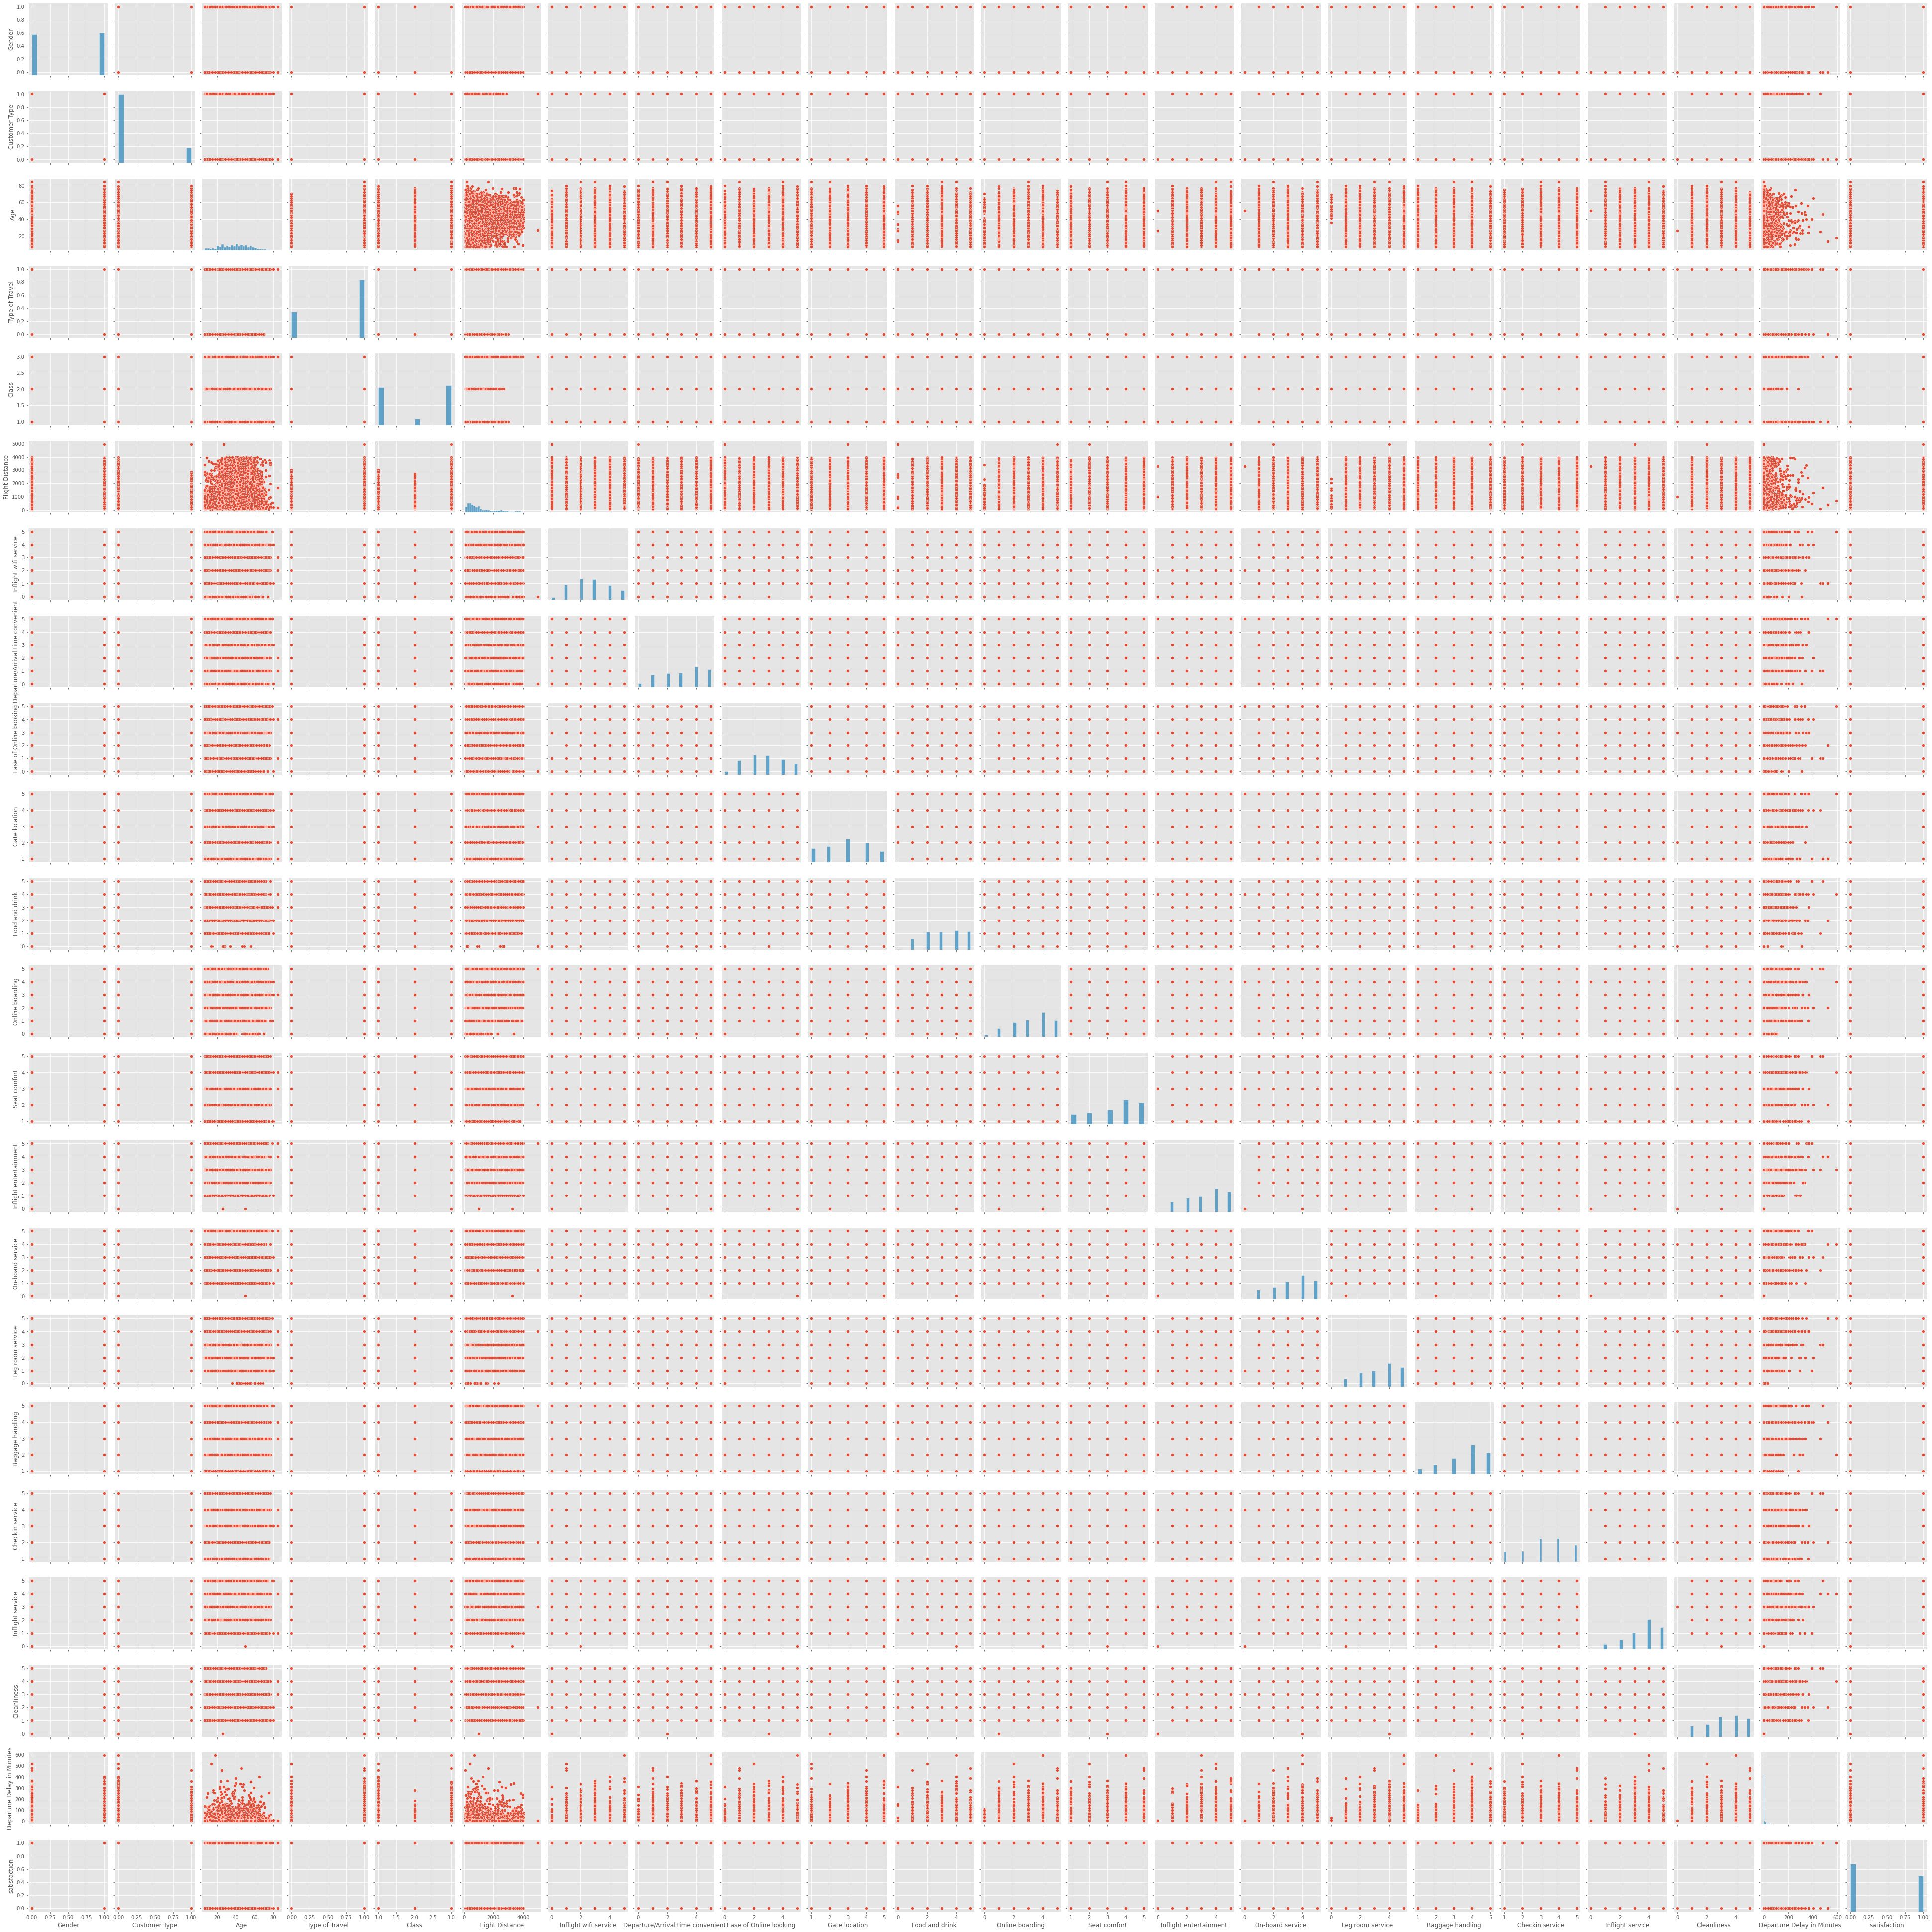

In [8]:
# Pairplot of ht entire dataset
plt.figure(figsize=(30,30))
sns.pairplot(X)
plt.show()

In [9]:
# Can be used to investigate the value counts for every category given the typ of travel
bus = (X['Type of Travel'] == 1)
pers = (X['Type of Travel'] == 0)
X[pers]['Gate location'].value_counts()

3    665
4    460
2    339
1    277
5    124
Name: Gate location, dtype: int64

In [10]:
X[bus]['satisfaction'].describe()

count    4135.000000
mean        0.578718
std         0.493824
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: satisfaction, dtype: float64

## Load the Graph Generated in The Data Script

In [11]:
A = np.loadtxt('adjacency_matrix.csv',delimiter=',')

In [12]:
np.diag(A).sum()

0.0

In [13]:
G = nx.from_numpy_matrix(A)

In [14]:
nx.is_connected(G)

True

## Dummy Code and Normalize the Data

In [15]:
features = pd.Series(X.satisfaction) # separate label from features
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

## Load and Pre-Process the Test Data in the exact same way as the Training Data

In [16]:
# Load Test Data
df_test = pd.read_csv('test.csv',sep=',')
df_test = df_test.sample(n=6000)
df_test.drop(columns=['Unnamed: 0','id'],inplace=True)
df_test.Gender = df_test.Gender.apply(lambda x: 0 if x == 'Male' else 1)
df_test['Customer Type'] = df_test['Customer Type'].apply(lambda x: 0 if x == 'Loyal Customer' else 1)
df_test['Type of Travel'] = df_test['Type of Travel'].apply(lambda x: 0 if x == 'Personal Travel' else 1)
df_test['Class'] = df_test['Class'].apply(lambda x: 0 if x == 'Eco' else(1 if x == 'Eco Plus' else 2))
df_test['satisfaction'] = df_test['satisfaction'].apply(lambda x: 0 if x == 'neutral or dissatisfied' else 1)
df_test.reset_index(drop=True,inplace=True)
df_test.drop(columns=['Arrival Delay in Minutes'],inplace = True)

In [17]:
TEST = df_test.copy(deep=True)

In [18]:
test_gen = TEST[['Gender','Customer Type','Age','Type of Travel','Class']].copy(deep=True)
test_gen.Age = test_gen.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [19]:
TEST.Class = TEST.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))

In [20]:
xx = TEST.drop(columns=['satisfaction'])
xx_dummy = pd.get_dummies(data=xx,columns=['Customer Type','Type of Travel','Gender'])
xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']])
yy = TEST.satisfaction

## Plot the Training- Validation Graph

In [21]:
pos = nx.spring_layout(G)

In [22]:
dissatisfied = df.index[df.satisfaction == 'neutral or dissatisfied'].tolist()
satisfied = df.index[df.satisfaction == 'satisfied'].tolist()

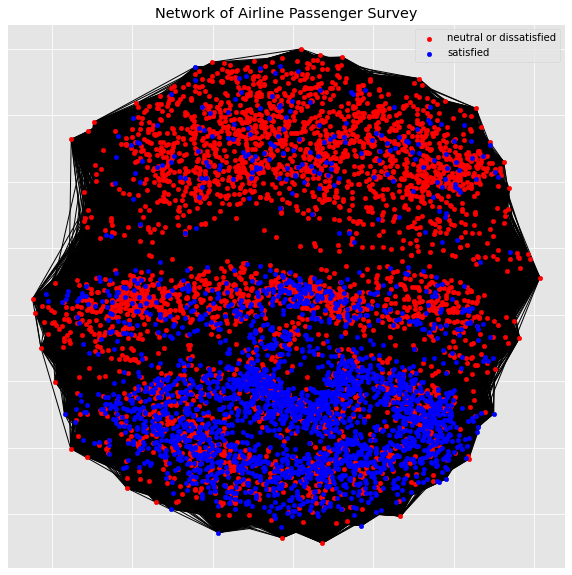

In [23]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r',label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b',label='satisfied')
nx.draw_networkx_edges(G,pos,label=None)
plt.title('Network of Airline Passenger Survey')
plt.legend()
plt.show()

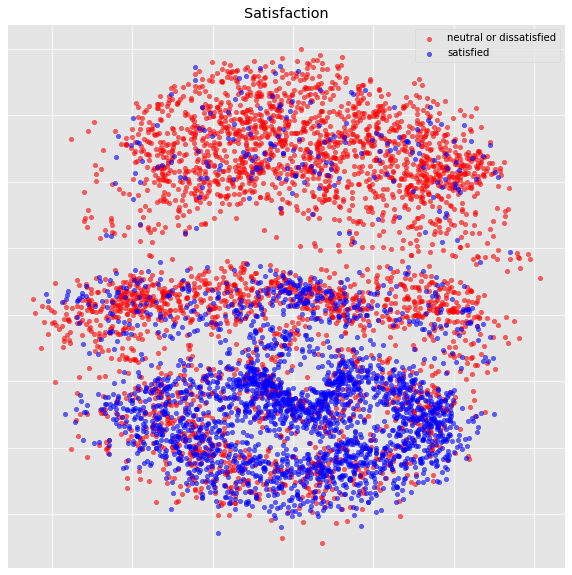

In [24]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.legend()
plt.title('Satisfaction')
plt.show()

<AxesSubplot:>

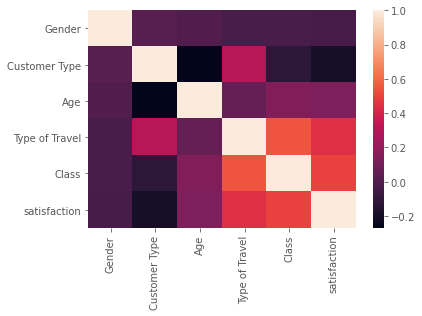

In [25]:
# correlation Map of the Attribute Variables and the Label
cormap_vars = X[['Gender','Customer Type','Age','Type of Travel','Class','satisfaction']]
cormap = cormap_vars.corr()
sns.heatmap(cormap)

In [26]:
male = df.index[df.Gender == 'Male'].tolist()
female = df.index[df.Gender == 'Female'].tolist()

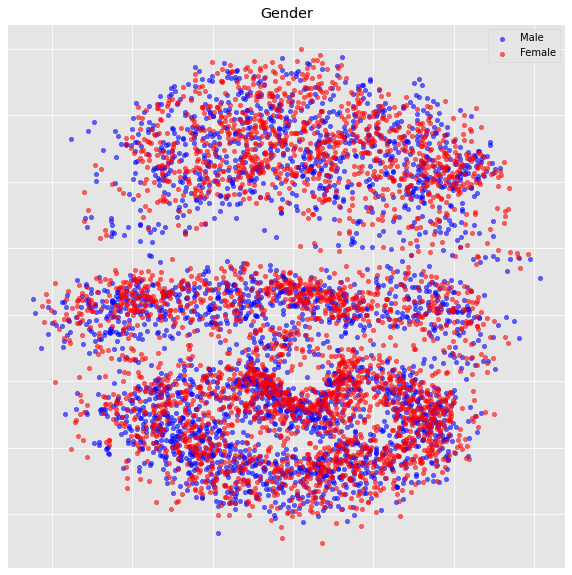

In [27]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.legend()
plt.title('Gender')
plt.show()

In [28]:
loyal = df.index[df['Customer Type'] == 'Loyal Customer'].tolist()
disloyal = df.index[df['Customer Type'] == 'disloyal Customer'].tolist()

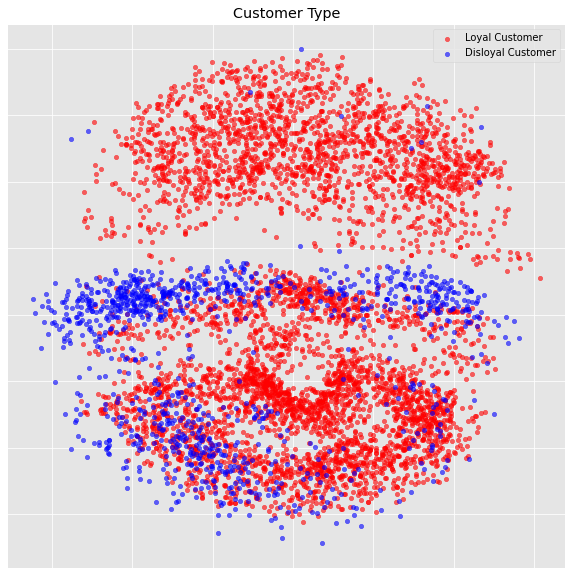

In [29]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.legend()
plt.title('Customer Type')
plt.show()

In [30]:
eco = df.index[df.Class == 'Eco'].tolist()
eco_plus = df.index[df.Class == 'Eco Plus'].tolist()
bus = df.index[df.Class == 'Business'].tolist()

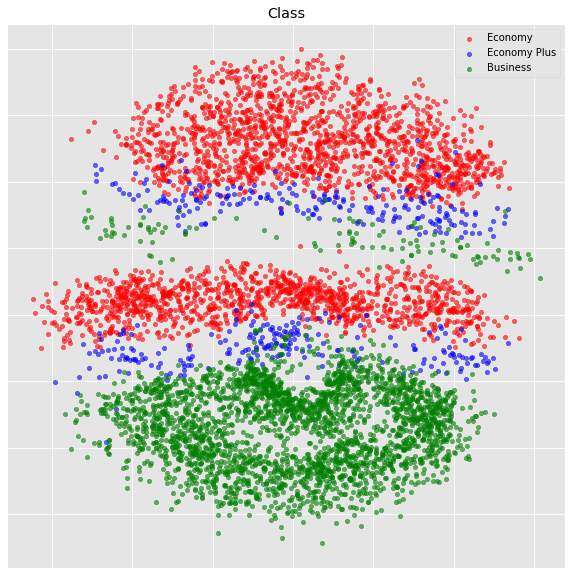

In [31]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.legend()
plt.title('Class')
plt.show()

In [32]:
personal = df.index[df['Type of Travel'] == 'Personal Travel'].tolist()
business = df.index[df['Type of Travel'] == 'Business travel'].tolist()

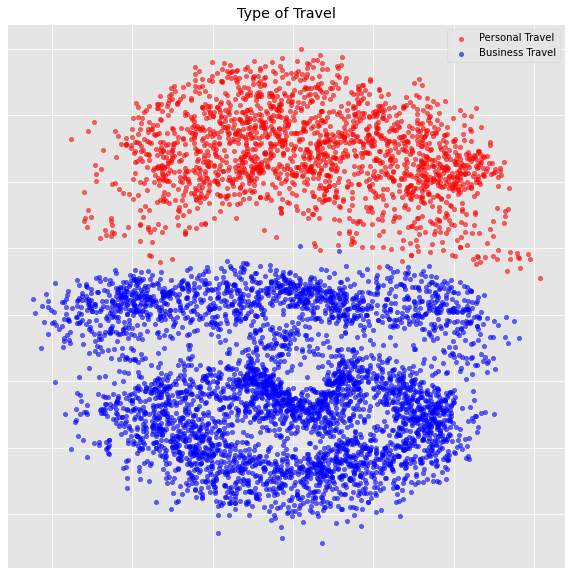

In [33]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.legend()
plt.title('Type of Travel')
plt.show()

In [34]:
AGE = df.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [35]:
age0 = AGE.index[AGE == 0].tolist()
age1 = AGE.index[AGE == 1].tolist()
age2 = AGE.index[AGE == 2].tolist()
age3 = AGE.index[AGE == 3].tolist()

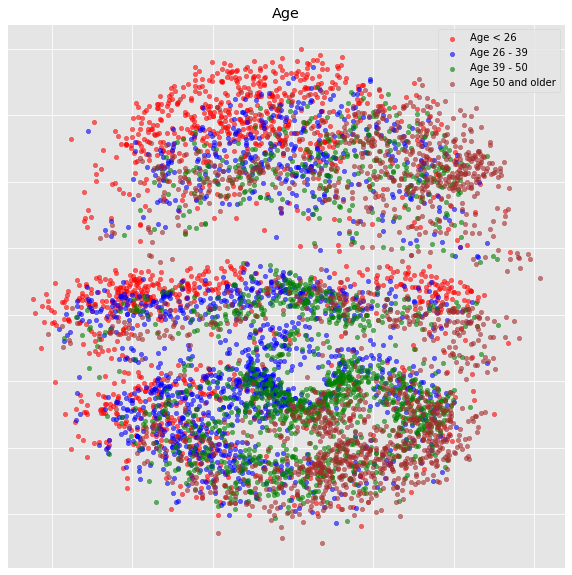

In [36]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older' )
plt.legend()
plt.title('Age')
plt.show()

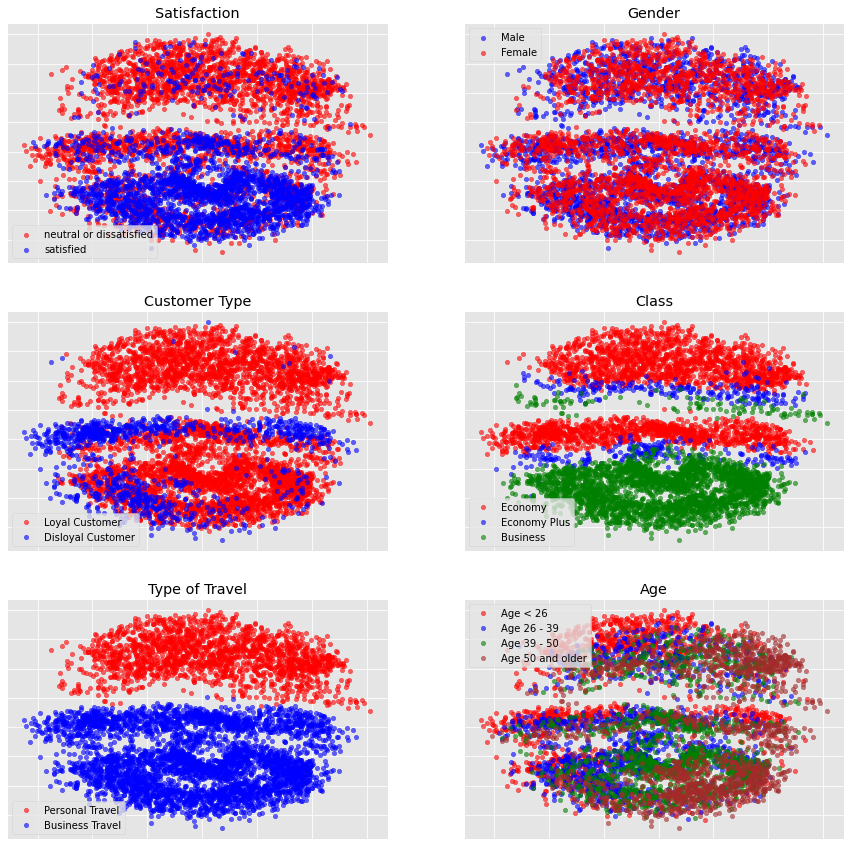

In [37]:
fig = plt.subplots(figsize=(15,15))

plt.subplot(321)
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.title('Satisfaction')
plt.legend()

plt.subplot(322)
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.title('Gender')
plt.legend()

plt.subplot(323)
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.title('Customer Type')
plt.legend()

plt.subplot(324)
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.title('Class')
plt.legend()

plt.subplot(325)
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.title('Type of Travel')
plt.legend()

plt.subplot(326)
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older')
plt.title('Age')
plt.legend()

plt.show()


## Assign the Graph Data to a dgl Graph and Prepare the Data for Machine Learning

In [38]:
G_dgl = dgl.from_networkx(G)

G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
G_dgl.ndata['label'] = torch.tensor(features)

In [39]:
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

In [40]:
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [41]:
train_nodes = (train_mask == True).nonzero(as_tuple=False)
train_nids = torch.reshape(train_nodes,(-1,))
valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
valid_nids = torch.reshape(valid_nodes,(-1,))

In [42]:
len(train_nids)

4788

In [43]:
len(valid_nids)

1212

## Define the Dataloaders

In [44]:
batch_size = 50
sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10])
train_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, train_nids, sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0
)

In [45]:
example_minibatch = next(iter(train_dataloader))
print(example_minibatch)

[tensor([5592, 1411, 5281,  ..., 3318,  613, 5087]), tensor([5592, 1411, 5281, 2493, 2799, 4865, 4383, 3482, 5127, 2107, 4220, 5376,
        2281, 5014, 2217, 3827, 5738, 2711, 4491, 2409, 3979,   72, 1990, 3181,
        5072, 1744,  391, 1083, 1930, 1722, 4901, 2039, 2061,  490, 1088,  989,
        2079, 5397, 4775, 4093, 3887, 5784, 1007, 4741, 2188, 4656, 3788,  588,
         779, 4309]), [Block(num_src_nodes=2433, num_dst_nodes=517, num_edges=2585), Block(num_src_nodes=517, num_dst_nodes=50, num_edges=500)]]


In [46]:
input_nodes, output_nodes, bipartites = example_minibatch
print("To compute {} nodes' output we need {} nodes' input features".format(len(output_nodes), len(input_nodes)))

To compute 50 nodes' output we need 2433 nodes' input features


In [47]:
print(bipartites)

[Block(num_src_nodes=2433, num_dst_nodes=517, num_edges=2585), Block(num_src_nodes=517, num_dst_nodes=50, num_edges=500)]


In [48]:
batch_size = len(valid_nids)
valid_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, valid_nids, sampler,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

## Define the GraphSage Model, Train and get Results

The aggregation types are named as follows:

- 'pool' = max-pooling
- 'mean' = mean aggregations
- 'lstm' = LSTM aggregation

For sum-pooling, the class SumSage is used where 'pool' refers to sum-pooling and makes used of the script in the file sage.py

Note, that the logSoftmax function is not defined in the Sage classes below for the final output layer. This is because, the logSoftmax function is automatically applied when calculating the loss using the F.cross_entropy function. For that reason, the logSoftmax function is applied separately in the training script for getting the predicted values. This is both true for the GraphSage and GCN models.

In [49]:
class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers,agg_type='pool'):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [50]:
## Used for sum-pooling
class SumSAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type='pool', bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
            
        return x

In [51]:
# choose between sumSage or the standard GraphSage models and define the optimizer

#model = SumSAGE(n_features, len(x_wd.T), n_labels, 2) #n_layers
model = SAGE(n_features, len(x_wd.T), n_labels, 2, agg_type='pool') #n_layers
opt = torch.optim.Adam(model.parameters(),lr=0.002)#deine optimizer

Below the GraphSage model is trained

In [52]:
# GraphSage
best_accuracy = 0
best_model_path = 'model.pt'
epoch_losses_train = []
plot_loss_valid = []
train_acc = []
valid_acc = []
dur = []

for epoch in range(400):
    t0 = time.time()
    model.train()
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
        inputs = node_features[input_nodes]
        labels = node_labels[output_nodes]
        logits = model(bipartites, inputs)
        predictions = F.log_softmax(logits,dim=1)

        loss = F.cross_entropy(logits, labels)
        loss_epoch += loss.detach().item()
        opt.zero_grad()
        loss.backward()
        opt.step()

        accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
        accuracy_epoch += accuracy
    accuracy_epoch /= (step + 1)
    loss_epoch /= (step + 1)
    epoch_losses_train.append(loss_epoch)
    train_acc.append(accuracy_epoch)
    print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
    model.eval()
    
    predictions = []
    labels = []
    with torch.no_grad():
        for input_nodes, output_nodes, bipartites in valid_dataloader:
            inputs = node_features[input_nodes]
            labels.append(node_labels[output_nodes].numpy())
            predictions.append(F.log_softmax(model(bipartites, inputs),dim=1).argmax(1).numpy())
            valid_logits = model(bipartites, inputs)
            valid_labels = node_labels[output_nodes]
            valid_loss = F.cross_entropy(valid_logits, valid_labels)

        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        
        accuracy = accuracy_score(labels, predictions)
        dur.append(time.time() - t0)
        print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
        valid_acc.append(accuracy.item())
        plot_loss_valid.append(valid_loss.item())
    
torch.save(model.state_dict(), best_model_path)


Epoch: 0, Training Accuracy: 0.626, Training Loss: 0.652
Epoch: 0, Validation Accuracy: 0.795, Validation Loss: 0.562, Time: 2.3304
Epoch: 1, Training Accuracy: 0.790, Training Loss: 0.494
Epoch: 1, Validation Accuracy: 0.824, Validation Loss: 0.422, Time: 2.3909
Epoch: 2, Training Accuracy: 0.837, Training Loss: 0.414
Epoch: 2, Validation Accuracy: 0.834, Validation Loss: 0.393, Time: 2.3554
Epoch: 3, Training Accuracy: 0.839, Training Loss: 0.394
Epoch: 3, Validation Accuracy: 0.862, Validation Loss: 0.342, Time: 2.2413
Epoch: 4, Training Accuracy: 0.854, Training Loss: 0.364
Epoch: 4, Validation Accuracy: 0.869, Validation Loss: 0.334, Time: 2.1993
Epoch: 5, Training Accuracy: 0.857, Training Loss: 0.361
Epoch: 5, Validation Accuracy: 0.881, Validation Loss: 0.313, Time: 2.0916
Epoch: 6, Training Accuracy: 0.863, Training Loss: 0.347
Epoch: 6, Validation Accuracy: 0.885, Validation Loss: 0.314, Time: 2.0062
Epoch: 7, Training Accuracy: 0.869, Training Loss: 0.332
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.937, Training Loss: 0.171
Epoch: 62, Validation Accuracy: 0.946, Validation Loss: 0.150, Time: 1.6117
Epoch: 63, Training Accuracy: 0.931, Training Loss: 0.172
Epoch: 63, Validation Accuracy: 0.951, Validation Loss: 0.141, Time: 1.6061
Epoch: 64, Training Accuracy: 0.930, Training Loss: 0.171
Epoch: 64, Validation Accuracy: 0.947, Validation Loss: 0.148, Time: 1.6014
Epoch: 65, Training Accuracy: 0.938, Training Loss: 0.160
Epoch: 65, Validation Accuracy: 0.954, Validation Loss: 0.132, Time: 1.5995
Epoch: 66, Training Accuracy: 0.932, Training Loss: 0.167
Epoch: 66, Validation Accuracy: 0.956, Validation Loss: 0.135, Time: 1.5994
Epoch: 67, Training Accuracy: 0.933, Training Loss: 0.168
Epoch: 67, Validation Accuracy: 0.950, Validation Loss: 0.136, Time: 1.5990
Epoch: 68, Training Accuracy: 0.931, Training Loss: 0.166
Epoch: 68, Validation Accuracy: 0.951, Validation Loss: 0.134, Time: 1.5993
Epoch: 69, Training Accuracy: 0.931, Training Loss: 0.172
Epoc

Epoch: 123, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 123, Validation Accuracy: 0.953, Validation Loss: 0.129, Time: 1.5512
Epoch: 124, Training Accuracy: 0.946, Training Loss: 0.142
Epoch: 124, Validation Accuracy: 0.956, Validation Loss: 0.125, Time: 1.5502
Epoch: 125, Training Accuracy: 0.947, Training Loss: 0.143
Epoch: 125, Validation Accuracy: 0.946, Validation Loss: 0.133, Time: 1.5496
Epoch: 126, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 126, Validation Accuracy: 0.944, Validation Loss: 0.129, Time: 1.5490
Epoch: 127, Training Accuracy: 0.941, Training Loss: 0.150
Epoch: 127, Validation Accuracy: 0.954, Validation Loss: 0.124, Time: 1.5481
Epoch: 128, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 128, Validation Accuracy: 0.942, Validation Loss: 0.145, Time: 1.5473
Epoch: 129, Training Accuracy: 0.944, Training Loss: 0.148
Epoch: 129, Validation Accuracy: 0.958, Validation Loss: 0.125, Time: 1.5473
Epoch: 130, Training Accuracy: 0.938, Training L

Epoch: 184, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 184, Validation Accuracy: 0.954, Validation Loss: 0.119, Time: 1.5384
Epoch: 185, Training Accuracy: 0.947, Training Loss: 0.142
Epoch: 185, Validation Accuracy: 0.959, Validation Loss: 0.123, Time: 1.5403
Epoch: 186, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 186, Validation Accuracy: 0.964, Validation Loss: 0.117, Time: 1.5445
Epoch: 187, Training Accuracy: 0.940, Training Loss: 0.143
Epoch: 187, Validation Accuracy: 0.953, Validation Loss: 0.141, Time: 1.5498
Epoch: 188, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 188, Validation Accuracy: 0.957, Validation Loss: 0.115, Time: 1.5515
Epoch: 189, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 189, Validation Accuracy: 0.953, Validation Loss: 0.123, Time: 1.5520
Epoch: 190, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 190, Validation Accuracy: 0.955, Validation Loss: 0.118, Time: 1.5513
Epoch: 191, Training Accuracy: 0.946, Training L

Epoch: 245, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 245, Validation Accuracy: 0.955, Validation Loss: 0.110, Time: 1.5586
Epoch: 246, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 246, Validation Accuracy: 0.959, Validation Loss: 0.113, Time: 1.5587
Epoch: 247, Training Accuracy: 0.947, Training Loss: 0.128
Epoch: 247, Validation Accuracy: 0.959, Validation Loss: 0.106, Time: 1.5588
Epoch: 248, Training Accuracy: 0.950, Training Loss: 0.121
Epoch: 248, Validation Accuracy: 0.955, Validation Loss: 0.129, Time: 1.5594
Epoch: 249, Training Accuracy: 0.943, Training Loss: 0.134
Epoch: 249, Validation Accuracy: 0.957, Validation Loss: 0.106, Time: 1.5603
Epoch: 250, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 250, Validation Accuracy: 0.957, Validation Loss: 0.109, Time: 1.5616
Epoch: 251, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 251, Validation Accuracy: 0.959, Validation Loss: 0.107, Time: 1.5618
Epoch: 252, Training Accuracy: 0.951, Training L

Epoch: 306, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 306, Validation Accuracy: 0.957, Validation Loss: 0.121, Time: 1.5939
Epoch: 307, Training Accuracy: 0.946, Training Loss: 0.127
Epoch: 307, Validation Accuracy: 0.960, Validation Loss: 0.113, Time: 1.5936
Epoch: 308, Training Accuracy: 0.952, Training Loss: 0.121
Epoch: 308, Validation Accuracy: 0.957, Validation Loss: 0.105, Time: 1.5935
Epoch: 309, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 309, Validation Accuracy: 0.958, Validation Loss: 0.101, Time: 1.5937
Epoch: 310, Training Accuracy: 0.944, Training Loss: 0.136
Epoch: 310, Validation Accuracy: 0.952, Validation Loss: 0.108, Time: 1.5935
Epoch: 311, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 311, Validation Accuracy: 0.958, Validation Loss: 0.108, Time: 1.5936
Epoch: 312, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 312, Validation Accuracy: 0.959, Validation Loss: 0.104, Time: 1.5937
Epoch: 313, Training Accuracy: 0.949, Training L

Epoch: 367, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 367, Validation Accuracy: 0.958, Validation Loss: 0.109, Time: 1.5810
Epoch: 368, Training Accuracy: 0.947, Training Loss: 0.127
Epoch: 368, Validation Accuracy: 0.955, Validation Loss: 0.116, Time: 1.5795
Epoch: 369, Training Accuracy: 0.948, Training Loss: 0.125
Epoch: 369, Validation Accuracy: 0.962, Validation Loss: 0.111, Time: 1.5780
Epoch: 370, Training Accuracy: 0.953, Training Loss: 0.118
Epoch: 370, Validation Accuracy: 0.959, Validation Loss: 0.108, Time: 1.5767
Epoch: 371, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 371, Validation Accuracy: 0.959, Validation Loss: 0.107, Time: 1.5758
Epoch: 372, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 372, Validation Accuracy: 0.955, Validation Loss: 0.114, Time: 1.5749
Epoch: 373, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 373, Validation Accuracy: 0.954, Validation Loss: 0.107, Time: 1.5739
Epoch: 374, Training Accuracy: 0.953, Training L

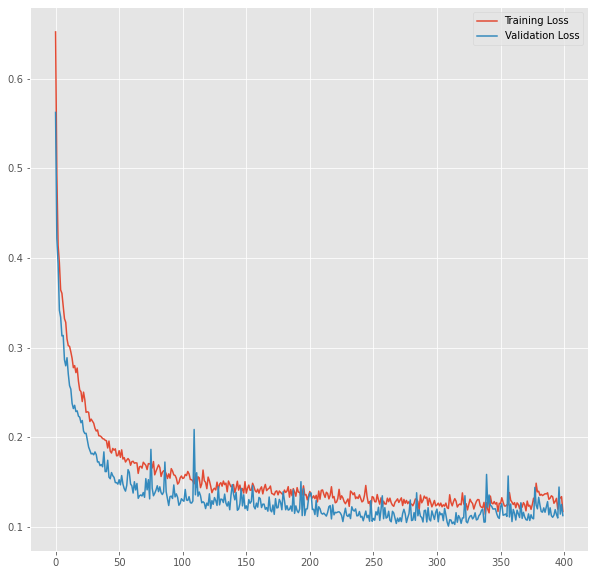

In [53]:
plt.figure(figsize=(10,10))
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.legend()
plt.show()

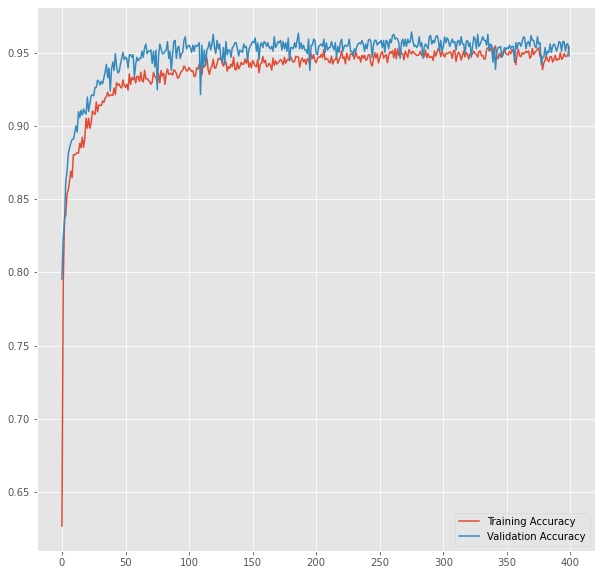

In [54]:
plt.figure(figsize=(10,10))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [55]:
print('Training Accuracy: {}'.format(train_acc[-1]))
print('Validation Accuracy: {}'.format(valid_acc[-1]))

Training Accuracy: 0.9542434210526317
Validation Accuracy: 0.948019801980198


In [56]:
np.argmax(valid_acc)

275

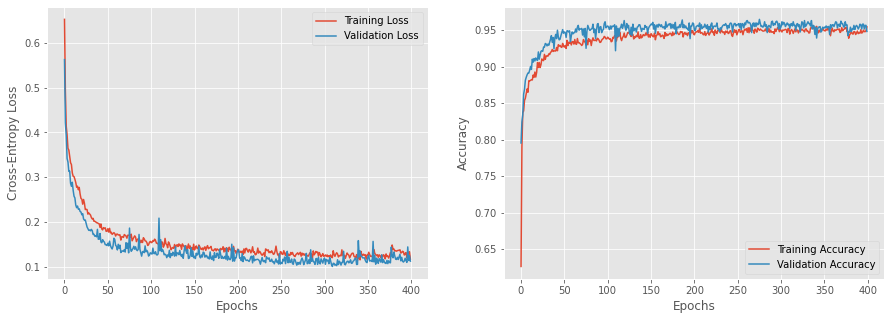

In [57]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [58]:
# shows the model parameters of the GraphSage model
model.parameters

<bound method Module.parameters of SAGE(
  (layers): ModuleList(
    (0): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (activation): ReLU()
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=24, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
    )
    (1): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=2, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
    )
  )
)>

## Graph Convolutional Network

Below the dgl data is reset to 30% training and 70 validation data which is then used for the GCN.

In [59]:
G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.3)
G_dgl.ndata['label'] = torch.tensor(features)

G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

Define the GCN network

In [60]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.pytorch.conv.GraphConv(
            in_feats=in_feats, out_feats=hid_feats,norm='both', weight=True, bias=True, activation=nn.ReLU(inplace=False))
        
        self.conv2 = dglnn.pytorch.conv.GraphConv(
            in_feats=hid_feats, out_feats=out_feats,norm='both', weight=True, bias=True, activation=None)
        
    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = self.conv2(graph, h)
        return h

Compile the model

In [61]:
model_gcn = GCN(n_features, len(x_wd.T) , n_labels) # 
opt = torch.optim.Adam(model_gcn.parameters(),lr=0.002)#GCN

In [62]:
def evaluate(model_gcn, graph, features, labels, mask):
    model_gcn.eval()
    with torch.no_grad():
        logits = model_gcn(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        preds = F.log_softmax(logits,dim=1)
        _, indices = torch.max(preds, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Train the model

In [63]:
#model = GCN(in_feats=n_features, hid_feats_1=128, hid_feats_2=128, out_feats=n_labels)
#opt = torch.optim.Adam(model.parameters(),lr=1e-2)
plot_loss_train = []
plot_loss_val = []
valid_acc = []
train_acc = []
dur = []
for epoch in range(1000):
    t0 = time.time()
    model_gcn.train()
    # forward propagation by using all nodes
    logits = model_gcn(G_dgl, node_features)
    # compute loss
    loss_train = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    acc_train = evaluate(model_gcn, G_dgl, node_features, node_labels, train_mask)
    train_acc.append(acc_train)
    plot_loss_train.append(loss_train.item())
    opt.zero_grad()
    loss_train.backward()
    opt.step()
    
    model_gcn.eval()
    
    # compute validation accuracy
    with torch.no_grad():
        acc_val = evaluate(model_gcn, G_dgl, node_features, node_labels, valid_mask)
        loss_val = F.cross_entropy(logits[valid_mask], node_labels[valid_mask])
        valid_acc.append(acc_val)
        plot_loss_val.append(loss_val.item())
    # backward propagation
    
    dur.append(time.time() - t0)
    if epoch % 10 == 0:
        print('Epoch: {}, train loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.4f}, validation accuracy: {:.4f}, Time: {:.4f}'.format(epoch,loss_train.item(),loss_val.item(),acc_train,acc_val,np.mean(dur)))


Epoch: 0, train loss: 1.0811, validation loss: 1.0879, training accuracy: 0.4298, validation accuracy: 0.4294, Time: 0.3479
Epoch: 10, train loss: 0.7398, validation loss: 0.7381, training accuracy: 0.5702, validation accuracy: 0.5706, Time: 0.3096
Epoch: 20, train loss: 0.6816, validation loss: 0.6817, training accuracy: 0.5702, validation accuracy: 0.5914, Time: 0.2994
Epoch: 30, train loss: 0.6802, validation loss: 0.6810, training accuracy: 0.6828, validation accuracy: 0.6219, Time: 0.3131
Epoch: 40, train loss: 0.6737, validation loss: 0.6736, training accuracy: 0.5702, validation accuracy: 0.5706, Time: 0.3310
Epoch: 50, train loss: 0.6651, validation loss: 0.6661, training accuracy: 0.6883, validation accuracy: 0.6974, Time: 0.3229
Epoch: 60, train loss: 0.6574, validation loss: 0.6582, training accuracy: 0.5702, validation accuracy: 0.5706, Time: 0.3166
Epoch: 70, train loss: 0.6498, validation loss: 0.6511, training accuracy: 0.5740, validation accuracy: 0.6121, Time: 0.3123
E

Epoch: 660, train loss: 0.4888, validation loss: 0.5010, training accuracy: 0.7865, validation accuracy: 0.7582, Time: 0.3662
Epoch: 670, train loss: 0.4882, validation loss: 0.5007, training accuracy: 0.7848, validation accuracy: 0.7582, Time: 0.3665
Epoch: 680, train loss: 0.4876, validation loss: 0.5004, training accuracy: 0.7842, validation accuracy: 0.7579, Time: 0.3684
Epoch: 690, train loss: 0.4870, validation loss: 0.5002, training accuracy: 0.7837, validation accuracy: 0.7584, Time: 0.3707
Epoch: 700, train loss: 0.4865, validation loss: 0.4997, training accuracy: 0.7815, validation accuracy: 0.7582, Time: 0.3804
Epoch: 710, train loss: 0.4860, validation loss: 0.4998, training accuracy: 0.7826, validation accuracy: 0.7579, Time: 0.3840
Epoch: 720, train loss: 0.4855, validation loss: 0.4993, training accuracy: 0.7815, validation accuracy: 0.7579, Time: 0.3931
Epoch: 730, train loss: 0.4851, validation loss: 0.4993, training accuracy: 0.7809, validation accuracy: 0.7577, Time:

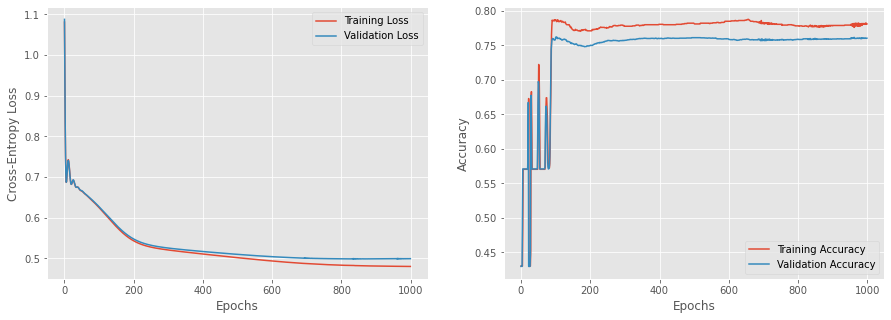

In [64]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(plot_loss_train,label='Training Loss')
plt.plot(plot_loss_val,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(valid_acc,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [65]:
val_tens = torch.tensor(features)
_, indices_val = torch.max(logits[valid_mask], dim=1)
val_lab = val_tens[valid_mask]
train_lab = val_tens[train_mask]
_, indices_train = torch.max(logits[train_mask], dim=1)

print('Classification Accuracy validation set {}'.format(accuracy_score(val_lab,indices_val)))
print('-------------------------------------------------------------')
print('Classification Accuracy training set {}'.format(accuracy_score(train_lab,indices_train)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(val_lab, indices_val))
print('-------------------------------------------------------------')
print('Confusion Matrix training set:')
print(confusion_matrix(train_lab,indices_train))


Classification Accuracy validation set 0.7600667143197523
-------------------------------------------------------------
Classification Accuracy training set 0.7809206877426511
-------------------------------------------------------------
Confusion Matrix validation set:
[[1830  565]
 [ 442 1360]]
-------------------------------------------------------------
Confusion Matrix training set:
[[818 210]
 [185 590]]


In [66]:
model_gcn.parameters

<bound method Module.parameters of GCN(
  (conv1): GraphConv(
    in=24, out=24, normalization=both
    (_activation): ReLU()
  )
  (conv2): GraphConv(in=24, out=2, normalization=both, activation=None)
)>

## Generate Test Graph

Based on the test data, a new test graph is generated. This is the same procedure as is done in the the data script. It is repeated here for the test graph so that every A-Z simulation contains a new test graph. This ensures, that there is not some graph sampling bias. Note, different training graphs were tested as well. The results are consistent regardless of the generated graph.

In [67]:
# gender
gend_alpha0 = 0.60
gend_beta1 = 0.40

aff_gend = np.array([[gend_alpha0,gend_beta1],
                     [gend_beta1,gend_alpha0]])

# customer type (loyal vs disoyal)

type_alpha0 = 0.8
type_beta1 = 0.5

aff_type = np.array([[type_alpha0, type_beta1],
                     [type_beta1, type_alpha0]])


# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta3,age_beta2,age_beta1,age_alpha0]])


# Type of travel
trav_type_alpha0 = 0.80
trav_type_beta1 = 0.20

aff_trav_type = np.array([[trav_type_alpha0, trav_type_beta1],
                          [trav_type_beta1, trav_type_alpha0]])

# Class

class_alpha0 = 0.85
class_beta1 = 0.60
class_beta2 = 0.40

aff_class = np.array([[class_alpha0, class_beta1, class_beta2],
                      [class_beta1, class_alpha0, class_beta1],
                      [class_beta2, class_beta1, class_alpha0]])


aff = {0:aff_gend, 1:aff_type, 2:aff_age, 3:aff_trav_type, 4:aff_class}

In [68]:
x = test_gen.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v)

In [69]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0

In [70]:
A = A + A.T

In [71]:
G_test = nx.from_numpy_matrix(A)

In [72]:
test_features = pd.Series(TEST.satisfaction)

## Assign the data to a dgl graph

In [73]:
G_dgl_test = dgl.from_networkx(G_test)
feat_test = TEST.drop(columns=['satisfaction'])
feat_test = pd.get_dummies(data=feat_test,columns=['Customer Type','Type of Travel','Gender'])
feat_test[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(feat_test[['Age','Departure Delay in Minutes','Flight Distance']])

G_dgl_test.ndata['feat'] =  torch.tensor(feat_test.values,dtype=torch.float)
G_dgl_test.ndata['label'] = torch.tensor(test_features)

In [74]:
node_features = G_dgl_test.ndata['feat']
node_labels = G_dgl_test.ndata['label']
test_nids = G_dgl_test.nodes()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

## Define the inference function to get the test graph results

In [75]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10]) 
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0]
                x = input_features[input_nodes]
                x = layer(bipartite, x)
                output_features[output_nodes] = x
            input_features = output_features
    return output_features

## Get the test graph results

In [76]:
model.load_state_dict(torch.load('model.pt'))
all_logits = inference(model, G_dgl_test, node_features, 6000)

100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


In [77]:
test_predictions = F.log_softmax(all_logits[test_nids],dim=1).argmax(1)
test_labels = node_labels[test_nids]
test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
print('Test accuracy:', test_accuracy)

Test accuracy: 0.9376666666666666


In [78]:
print('Classification Accuracy test set {}'.format(accuracy_score(test_labels.numpy(),test_predictions.numpy())))
print('-------------------------------------------------------------')
print('Confusion Matrix test set:')
print(confusion_matrix(test_labels.numpy(),test_predictions.numpy()))

Classification Accuracy test set 0.9376666666666666
-------------------------------------------------------------
Confusion Matrix test set:
[[3193  226]
 [ 148 2433]]


In [79]:
sklearn.metrics.f1_score(test_labels.numpy(),test_predictions.numpy(),average='micro')

0.9376666666666666

In [80]:
test_loss = F.cross_entropy(all_logits[test_nids],test_labels).numpy()
test_loss

array(0.14549877, dtype=float32)

In [81]:
model.layers

ModuleList(
  (0): SAGEConv(
    (feat_drop): Dropout(p=0.02, inplace=False)
    (activation): ReLU()
    (fc_pool): Linear(in_features=24, out_features=24, bias=True)
    (fc_self): Linear(in_features=24, out_features=24, bias=False)
    (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
  )
  (1): SAGEConv(
    (feat_drop): Dropout(p=0.02, inplace=False)
    (fc_pool): Linear(in_features=24, out_features=24, bias=True)
    (fc_self): Linear(in_features=24, out_features=2, bias=False)
    (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
  )
)

## ANN Simulations

The following code was used to simulated the consistency of ANN results. This was done to compare the ANN results with the GNN results.

In [82]:
f = pd.get_dummies(features)
yy_test = pd.get_dummies(yy)


model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

def sim_ann(model,opt,f,x_wd,xx_dummy,yy_test):
    train_loss = []
    val_loss = []
    test_loss = []
    train_acc = []
    val_acc = []
    test_acc = []
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

        x_train_tf = tf.convert_to_tensor(x_train)
        x_test_tf = tf.convert_to_tensor(x_test)
        y_train_tf = tf.convert_to_tensor(y_train)
        y_test_tf = tf.convert_to_tensor(y_test)

        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=400, batch_size=50)
        
        train_loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        train_acc.append(history.history['accuracy'][-1])
        val_acc.append(history.history['val_accuracy'][-1])
        
        results = model.evaluate(xx_dummy, yy_test, batch_size=128)
        test_loss.append(results[0])
        test_acc.append(results[1])
        print("test loss, test acc:", results)
    
    return train_loss, val_loss, test_loss, train_acc, val_acc, test_acc
        
train_loss, val_loss, test_loss, train_acc, val_acc, test_acc = sim_ann(model,opt,f,x_wd,xx_dummy,yy_test)
        
    

Epoch 1/400
96/96 [==============================] - 3s 18ms/step - loss: 0.7849 - accuracy: 0.5632 - val_loss: 0.5196 - val_accuracy: 0.7675
Epoch 2/400
96/96 [==============================] - 0s 4ms/step - loss: 0.5704 - accuracy: 0.7709 - val_loss: 0.4278 - val_accuracy: 0.8367
Epoch 3/400
96/96 [==============================] - 0s 4ms/step - loss: 0.4964 - accuracy: 0.8275 - val_loss: 0.3815 - val_accuracy: 0.8533
Epoch 4/400
96/96 [==============================] - 0s 4ms/step - loss: 0.4203 - accuracy: 0.8552 - val_loss: 0.3727 - val_accuracy: 0.8533
Epoch 5/400
96/96 [==============================] - 0s 3ms/step - loss: 0.4328 - accuracy: 0.8503 - val_loss: 0.3482 - val_accuracy: 0.8650
Epoch 6/400
96/96 [==============================] - 0s 4ms/step - loss: 0.4318 - accuracy: 0.8688 - val_loss: 0.3437 - val_accuracy: 0.8642
Epoch 7/400
96/96 [==============================] - 0s 3ms/step - loss: 0.4135 - accuracy: 0.8653 - val_loss: 0.3229 - val_accuracy: 0.8750
Epoch 8/400


Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2489 - accuracy: 0.9276 - val_loss: 0.1646 - val_accuracy: 0.9342
Epoch 60/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2431 - accuracy: 0.9308 - val_loss: 0.1600 - val_accuracy: 0.9383
Epoch 61/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2428 - accuracy: 0.9319 - val_loss: 0.1600 - val_accuracy: 0.9350
Epoch 62/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2333 - accuracy: 0.9323 - val_loss: 0.1591 - val_accuracy: 0.9375
Epoch 63/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2424 - accuracy: 0.9280 - val_loss: 0.1581 - val_accuracy: 0.9392
Epoch 64/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2344 - accuracy: 0.9277 - val_loss: 0.1857 - val_accuracy: 0.9292
Epoch 65/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2534 - accuracy: 0.9273 - val_loss: 0.1600 - val_accuracy: 0.9367
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.1934 - accuracy: 0.9444 - val_loss: 0.1690 - val_accuracy: 0.9267
Epoch 117/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2036 - accuracy: 0.9417 - val_loss: 0.1468 - val_accuracy: 0.9458
Epoch 118/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2121 - accuracy: 0.9397 - val_loss: 0.1494 - val_accuracy: 0.9442
Epoch 119/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1974 - accuracy: 0.9401 - val_loss: 0.1453 - val_accuracy: 0.9433
Epoch 120/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2059 - accuracy: 0.9413 - val_loss: 0.1503 - val_accuracy: 0.9433
Epoch 121/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1903 - accuracy: 0.9415 - val_loss: 0.1465 - val_accuracy: 0.9408
Epoch 122/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1942 - accuracy: 0.9483 - val_loss: 0.1451 - val_accuracy: 0.9442
Epoch 123/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1894 - accuracy: 0.9448 - val_loss: 0.1521 - val_accuracy: 0.9433
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2169 - accuracy: 0.9442 - val_loss: 0.1538 - val_accuracy: 0.9425
Epoch 175/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1731 - accuracy: 0.9451 - val_loss: 0.1452 - val_accuracy: 0.9450
Epoch 176/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1797 - accuracy: 0.9468 - val_loss: 0.1457 - val_accuracy: 0.9400
Epoch 177/400
96/96 [==============================] - 1s 5ms/step - loss: 0.2131 - accuracy: 0.9437 - val_loss: 0.1474 - val_accuracy: 0.9392
Epoch 178/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2093 - accuracy: 0.9428 - val_loss: 0.1500 - val_accuracy: 0.9417
Epoch 179/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1969 - accuracy: 0.9411 - val_loss: 0.1482 - val_accuracy: 0.9442
Epoch 180/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2106 - accuracy: 0.9417 - val_loss: 0.1488 - val_accuracy: 0.9467
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1930 - accuracy: 0.9441 - val_loss: 0.1472 - val_accuracy: 0.9450
Epoch 232/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2023 - accuracy: 0.9478 - val_loss: 0.1505 - val_accuracy: 0.9392
Epoch 233/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2242 - accuracy: 0.9378 - val_loss: 0.1453 - val_accuracy: 0.9417
Epoch 234/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1789 - accuracy: 0.9512 - val_loss: 0.3643 - val_accuracy: 0.8275
Epoch 235/400
96/96 [==============================] - 0s 2ms/step - loss: 0.3873 - accuracy: 0.8663 - val_loss: 0.1650 - val_accuracy: 0.9283
Epoch 236/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2231 - accuracy: 0.9358 - val_loss: 0.1565 - val_accuracy: 0.9383
Epoch 237/400

96/96 [==============================] - 0s 3ms/step - loss: 0.2223 - accuracy: 0.9421 - val_loss: 0.1449 - val_accuracy: 0.9375
Epoch 288/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1800 - accuracy: 0.9500 - val_loss: 0.1374 - val_accuracy: 0.9400
Epoch 289/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1997 - accuracy: 0.9500 - val_loss: 0.1336 - val_accuracy: 0.9475
Epoch 290/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1868 - accuracy: 0.9483 - val_loss: 0.1358 - val_accuracy: 0.9500
Epoch 291/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1510 - accuracy: 0.9535 - val_loss: 0.1310 - val_accuracy: 0.9483
Epoch 292/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1612 - accuracy: 0.9566 - val_loss: 0.1363 - val_accuracy: 0.9483
Epoch 293/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1687 - accuracy: 0.9450 - val_loss: 0.1351 - val_accuracy: 0.9467
Epoch 294/400

96/96 [==============================] - 0s 4ms/step - loss: 0.1537 - accuracy: 0.9548 - val_loss: 0.1411 - val_accuracy: 0.9383
Epoch 345/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1625 - accuracy: 0.9499 - val_loss: 0.1488 - val_accuracy: 0.9392
Epoch 346/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1627 - accuracy: 0.9576 - val_loss: 0.1492 - val_accuracy: 0.9350
Epoch 347/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1592 - accuracy: 0.9557 - val_loss: 0.1383 - val_accuracy: 0.9383
Epoch 348/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1530 - accuracy: 0.9579 - val_loss: 0.1381 - val_accuracy: 0.9392
Epoch 349/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1464 - accuracy: 0.9548 - val_loss: 0.1547 - val_accuracy: 0.9292
Epoch 350/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1686 - accuracy: 0.9515 - val_loss: 0.1741 - val_accuracy: 0.9225
Epoch 351/400

47/47 [==============================] - 0s 1ms/step - loss: 0.1560 - accuracy: 0.9372
test loss, test acc: [0.15602609515190125, 0.937166690826416]
Epoch 1/400
96/96 [==============================] - 1s 3ms/step - loss: 0.2007 - accuracy: 0.9391 - val_loss: 0.1152 - val_accuracy: 0.9492
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2148 - accuracy: 0.9408 - val_loss: 0.1151 - val_accuracy: 0.9500
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2058 - accuracy: 0.9406 - val_loss: 0.1230 - val_accuracy: 0.9458
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1954 - accuracy: 0.9418 - val_loss: 0.1167 - val_accuracy: 0.9492
Epoch 5/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2099 - accuracy: 0.9407 - val_loss: 0.1119 - val_accuracy: 0.9525
Epoch 6/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1959 - accuracy: 0.9412 - val_loss: 0.1149 - val_accuracy: 0.9467
Epoch

Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1698 - accuracy: 0.9543 - val_loss: 0.1206 - val_accuracy: 0.9483
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1704 - accuracy: 0.9513 - val_loss: 0.1251 - val_accuracy: 0.9525
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1861 - accuracy: 0.9510 - val_loss: 0.1269 - val_accuracy: 0.9483
Epoch 61/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1853 - accuracy: 0.9550 - val_loss: 0.1230 - val_accuracy: 0.9483
Epoch 62/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1721 - accuracy: 0.9555 - val_loss: 0.1506 - val_accuracy: 0.9292
Epoch 63/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1791 - accuracy: 0.9515 - val_loss: 0.1187 - val_accuracy: 0.9500
Epoch 64/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1436 - accuracy: 0.9556 - val_loss: 0.1275 - val_accuracy: 0.9400
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1920 - accuracy: 0.9470 - val_loss: 0.1335 - val_accuracy: 0.9442
Epoch 116/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1592 - accuracy: 0.9580 - val_loss: 0.1378 - val_accuracy: 0.9475
Epoch 117/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1279 - accuracy: 0.9607 - val_loss: 0.1293 - val_accuracy: 0.9458
Epoch 118/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1392 - accuracy: 0.9597 - val_loss: 0.1355 - val_accuracy: 0.9475
Epoch 119/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1783 - accuracy: 0.9504 - val_loss: 0.1243 - val_accuracy: 0.9467
Epoch 120/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1465 - accuracy: 0.9571 - val_loss: 0.1351 - val_accuracy: 0.9467
Epoch 121/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1907 - accuracy: 0.9503 - val_loss: 0.1243 - val_accuracy: 0.9467
Epoch 122/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1562 - accuracy: 0.9561 - val_loss: 0.1358 - val_accuracy: 0.9450
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1492 - accuracy: 0.9573 - val_loss: 0.1307 - val_accuracy: 0.9442
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.9553 - val_loss: 0.1385 - val_accuracy: 0.9467
Epoch 175/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1469 - accuracy: 0.9595 - val_loss: 0.1327 - val_accuracy: 0.9433
Epoch 176/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1743 - accuracy: 0.9557 - val_loss: 0.1288 - val_accuracy: 0.9475
Epoch 177/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1540 - accuracy: 0.9569 - val_loss: 0.1421 - val_accuracy: 0.9500
Epoch 178/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1542 - accuracy: 0.9599 - val_loss: 0.1327 - val_accuracy: 0.9467
Epoch 179/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1988 - accuracy: 0.9496 - val_loss: 0.1374 - val_accuracy: 0.9450
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1731 - accuracy: 0.9544 - val_loss: 0.1441 - val_accuracy: 0.9400
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1754 - accuracy: 0.9506 - val_loss: 0.1489 - val_accuracy: 0.9483
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1494 - accuracy: 0.9606 - val_loss: 0.1361 - val_accuracy: 0.9442
Epoch 233/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1265 - accuracy: 0.9612 - val_loss: 0.1631 - val_accuracy: 0.9467
Epoch 234/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1557 - accuracy: 0.9547 - val_loss: 0.1395 - val_accuracy: 0.9483
Epoch 235/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1674 - accuracy: 0.9521 - val_loss: 0.1432 - val_accuracy: 0.9408
Epoch 236/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1516 - accuracy: 0.9558 - val_loss: 0.1527 - val_accuracy: 0.9442
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1484 - accuracy: 0.9615 - val_loss: 0.1582 - val_accuracy: 0.9442
Epoch 288/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1815 - accuracy: 0.9565 - val_loss: 0.1487 - val_accuracy: 0.9442
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1538 - accuracy: 0.9572 - val_loss: 0.1540 - val_accuracy: 0.9425
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1570 - accuracy: 0.9543 - val_loss: 0.1502 - val_accuracy: 0.9433
Epoch 291/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1641 - accuracy: 0.9570 - val_loss: 0.1493 - val_accuracy: 0.9467
Epoch 292/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1388 - accuracy: 0.9623 - val_loss: 0.1468 - val_accuracy: 0.9433
Epoch 293/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1744 - accuracy: 0.9599 - val_loss: 0.1806 - val_accuracy: 0.9400
Epoch 344/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1556 - accuracy: 0.9580 - val_loss: 0.1602 - val_accuracy: 0.9425
Epoch 345/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1521 - accuracy: 0.9608 - val_loss: 0.1694 - val_accuracy: 0.9425
Epoch 346/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1675 - accuracy: 0.9564 - val_loss: 0.1605 - val_accuracy: 0.9400
Epoch 347/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1399 - accuracy: 0.9619 - val_loss: 0.1628 - val_accuracy: 0.9392
Epoch 348/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1759 - accuracy: 0.9542 - val_loss: 0.1684 - val_accuracy: 0.9417
Epoch 349/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1841 - accuracy: 0.9537 - val_loss: 0.1563 - val_accuracy: 0.9467
Epoch 350/400

47/47 [==============================] - 0s 3ms/step - loss: 0.1785 - accuracy: 0.9418
test loss, test acc: [0.1784764975309372, 0.9418333172798157]
Epoch 1/400
96/96 [==============================] - 1s 4ms/step - loss: 0.2358 - accuracy: 0.9484 - val_loss: 0.1076 - val_accuracy: 0.9567
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1845 - accuracy: 0.9530 - val_loss: 0.1067 - val_accuracy: 0.9542
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1663 - accuracy: 0.9551 - val_loss: 0.1023 - val_accuracy: 0.9558
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1598 - accuracy: 0.9577 - val_loss: 0.1022 - val_accuracy: 0.9517
Epoch 5/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1674 - accuracy: 0.9587 - val_loss: 0.0994 - val_accuracy: 0.9567
Epoch 6/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2667 - accuracy: 0.9406 - val_loss: 0.2010 - val_accuracy: 0.9258
Epoch

Epoch 57/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1655 - accuracy: 0.9610 - val_loss: 0.1257 - val_accuracy: 0.9450
Epoch 58/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1709 - accuracy: 0.9554 - val_loss: 0.1316 - val_accuracy: 0.9500
Epoch 59/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1613 - accuracy: 0.9540 - val_loss: 0.1199 - val_accuracy: 0.9458
Epoch 60/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1924 - accuracy: 0.9517 - val_loss: 0.1240 - val_accuracy: 0.9425
Epoch 61/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1872 - accuracy: 0.9547 - val_loss: 0.1162 - val_accuracy: 0.9475
Epoch 62/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1795 - accuracy: 0.9576 - val_loss: 0.1368 - val_accuracy: 0.9467
Epoch 63/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1520 - accuracy: 0.9575 - val_loss: 0.1135 - val_accuracy: 0.9517
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.1660 - accuracy: 0.9577 - val_loss: 0.1252 - val_accuracy: 0.9467
Epoch 115/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1673 - accuracy: 0.9556 - val_loss: 0.1260 - val_accuracy: 0.9433
Epoch 116/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1782 - accuracy: 0.9523 - val_loss: 0.1271 - val_accuracy: 0.9425
Epoch 117/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1677 - accuracy: 0.9602 - val_loss: 0.1304 - val_accuracy: 0.9475
Epoch 118/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1761 - accuracy: 0.9580 - val_loss: 0.1330 - val_accuracy: 0.9467
Epoch 119/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1713 - accuracy: 0.9580 - val_loss: 0.1349 - val_accuracy: 0.9475
Epoch 120/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1564 - accuracy: 0.9569 - val_loss: 0.1375 - val_accuracy: 0.9442
Epoch 121/400

96/96 [==============================] - 1s 5ms/step - loss: 0.1626 - accuracy: 0.9513 - val_loss: 0.1350 - val_accuracy: 0.9425
Epoch 172/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1631 - accuracy: 0.9583 - val_loss: 0.1426 - val_accuracy: 0.9392
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1505 - accuracy: 0.9606 - val_loss: 0.1361 - val_accuracy: 0.9442
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1687 - accuracy: 0.9585 - val_loss: 0.1352 - val_accuracy: 0.9467
Epoch 175/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1510 - accuracy: 0.9615 - val_loss: 0.1362 - val_accuracy: 0.9442
Epoch 176/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1584 - accuracy: 0.9606 - val_loss: 0.1468 - val_accuracy: 0.9375
Epoch 177/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1605 - accuracy: 0.9618 - val_loss: 0.1354 - val_accuracy: 0.9458
Epoch 178/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1773 - accuracy: 0.9547 - val_loss: 0.1803 - val_accuracy: 0.9308
Epoch 229/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1897 - accuracy: 0.9457 - val_loss: 0.1694 - val_accuracy: 0.9375
Epoch 230/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2117 - accuracy: 0.9457 - val_loss: 0.1476 - val_accuracy: 0.9425
Epoch 231/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2137 - accuracy: 0.9429 - val_loss: 0.1706 - val_accuracy: 0.9408
Epoch 232/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2083 - accuracy: 0.9489 - val_loss: 0.1518 - val_accuracy: 0.9383
Epoch 233/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2219 - accuracy: 0.9394 - val_loss: 0.1502 - val_accuracy: 0.9425
Epoch 234/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1588 - accuracy: 0.9486 - val_loss: 0.1428 - val_accuracy: 0.9375
Epoch 235/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1509 - accuracy: 0.9608 - val_loss: 0.1549 - val_accuracy: 0.9433
Epoch 286/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2198 - accuracy: 0.9442 - val_loss: 0.1609 - val_accuracy: 0.9350
Epoch 287/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1607 - accuracy: 0.9571 - val_loss: 0.1472 - val_accuracy: 0.9400
Epoch 288/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1795 - accuracy: 0.9560 - val_loss: 0.1460 - val_accuracy: 0.9433
Epoch 289/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1338 - accuracy: 0.9637 - val_loss: 0.1527 - val_accuracy: 0.9442
Epoch 290/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1669 - accuracy: 0.9578 - val_loss: 0.1458 - val_accuracy: 0.9442
Epoch 291/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1645 - accuracy: 0.9602 - val_loss: 0.1410 - val_accuracy: 0.9442
Epoch 292/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1620 - accuracy: 0.9565 - val_loss: 0.1506 - val_accuracy: 0.9442
Epoch 343/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1782 - accuracy: 0.9573 - val_loss: 0.1492 - val_accuracy: 0.9417
Epoch 344/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2041 - accuracy: 0.9523 - val_loss: 0.1476 - val_accuracy: 0.9450
Epoch 345/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1858 - accuracy: 0.9556 - val_loss: 0.1546 - val_accuracy: 0.9442
Epoch 346/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1709 - accuracy: 0.9583 - val_loss: 0.1409 - val_accuracy: 0.9433
Epoch 347/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1455 - accuracy: 0.9604 - val_loss: 0.1448 - val_accuracy: 0.9433
Epoch 348/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1761 - accuracy: 0.9601 - val_loss: 0.1477 - val_accuracy: 0.9450
Epoch 349/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1765 - accuracy: 0.9554 - val_loss: 0.1566 - val_accuracy: 0.9425
Epoch 400/400
47/47 [==============================] - 0s 2ms/step - loss: 0.1616 - accuracy: 0.9415
test loss, test acc: [0.1615912914276123, 0.9415000081062317]
Epoch 1/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1706 - accuracy: 0.9548 - val_loss: 0.1042 - val_accuracy: 0.9592
Epoch 2/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1645 - accuracy: 0.9510 - val_loss: 0.0995 - val_accuracy: 0.9642
Epoch 3/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1595 - accuracy: 0.9561 - val_loss: 0.1035 - val_accuracy: 0.9575
Epoch 4/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1677 - accuracy: 0.9605 - val_loss: 0.1018 - val_accuracy: 0.9625
Epoch 5/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1752 - accuracy: 0.9590 - val_loss: 0.1073 - val_accuracy: 0.9608
Epo

Epoch 56/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1545 - accuracy: 0.9571 - val_loss: 0.1196 - val_accuracy: 0.9600
Epoch 57/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1717 - accuracy: 0.9582 - val_loss: 0.1215 - val_accuracy: 0.9558
Epoch 58/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1681 - accuracy: 0.9597 - val_loss: 0.1178 - val_accuracy: 0.9542
Epoch 59/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1659 - accuracy: 0.9580 - val_loss: 0.1149 - val_accuracy: 0.9567
Epoch 60/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1483 - accuracy: 0.9561 - val_loss: 0.1198 - val_accuracy: 0.9575
Epoch 61/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1871 - accuracy: 0.9526 - val_loss: 0.1152 - val_accuracy: 0.9567
Epoch 62/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2056 - accuracy: 0.9502 - val_loss: 0.1160 - val_accuracy: 0.9592
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.1465 - accuracy: 0.9555 - val_loss: 0.1433 - val_accuracy: 0.9425
Epoch 114/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1760 - accuracy: 0.9517 - val_loss: 0.1220 - val_accuracy: 0.9567
Epoch 115/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1562 - accuracy: 0.9558 - val_loss: 0.1233 - val_accuracy: 0.9542
Epoch 116/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1497 - accuracy: 0.9578 - val_loss: 0.1236 - val_accuracy: 0.9558
Epoch 117/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1610 - accuracy: 0.9603 - val_loss: 0.1275 - val_accuracy: 0.9558
Epoch 118/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1542 - accuracy: 0.9586 - val_loss: 0.1279 - val_accuracy: 0.9533
Epoch 119/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1576 - accuracy: 0.9572 - val_loss: 0.1258 - val_accuracy: 0.9525
Epoch 120/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1709 - accuracy: 0.9549 - val_loss: 0.1307 - val_accuracy: 0.9500
Epoch 171/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1761 - accuracy: 0.9566 - val_loss: 0.1321 - val_accuracy: 0.9525
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1680 - accuracy: 0.9504 - val_loss: 0.1264 - val_accuracy: 0.9550
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1980 - accuracy: 0.9507 - val_loss: 0.1311 - val_accuracy: 0.9525
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1367 - accuracy: 0.9648 - val_loss: 0.1290 - val_accuracy: 0.9508
Epoch 175/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1598 - accuracy: 0.9592 - val_loss: 0.1331 - val_accuracy: 0.9483
Epoch 176/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1562 - accuracy: 0.9564 - val_loss: 0.1277 - val_accuracy: 0.9550
Epoch 177/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1629 - accuracy: 0.9575 - val_loss: 0.1374 - val_accuracy: 0.9517
Epoch 228/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1413 - accuracy: 0.9632 - val_loss: 0.1324 - val_accuracy: 0.9533
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1471 - accuracy: 0.9601 - val_loss: 0.1307 - val_accuracy: 0.9525
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1606 - accuracy: 0.9552 - val_loss: 0.1327 - val_accuracy: 0.9525
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1589 - accuracy: 0.9596 - val_loss: 0.1396 - val_accuracy: 0.9483
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1620 - accuracy: 0.9592 - val_loss: 0.1314 - val_accuracy: 0.9533
Epoch 233/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1473 - accuracy: 0.9595 - val_loss: 0.1358 - val_accuracy: 0.9492
Epoch 234/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1562 - accuracy: 0.9606 - val_loss: 0.1351 - val_accuracy: 0.9525
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1749 - accuracy: 0.9586 - val_loss: 0.1360 - val_accuracy: 0.9517
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1484 - accuracy: 0.9599 - val_loss: 0.1662 - val_accuracy: 0.9300
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2006 - accuracy: 0.9391 - val_loss: 0.1410 - val_accuracy: 0.9408
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1678 - accuracy: 0.9535 - val_loss: 0.1443 - val_accuracy: 0.9442
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1758 - accuracy: 0.9549 - val_loss: 0.1261 - val_accuracy: 0.9533
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1572 - accuracy: 0.9581 - val_loss: 0.1280 - val_accuracy: 0.9525
Epoch 291/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1574 - accuracy: 0.9569 - val_loss: 0.1366 - val_accuracy: 0.9525
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1538 - accuracy: 0.9596 - val_loss: 0.1360 - val_accuracy: 0.9533
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1511 - accuracy: 0.9556 - val_loss: 0.1343 - val_accuracy: 0.9517
Epoch 344/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1662 - accuracy: 0.9610 - val_loss: 0.1364 - val_accuracy: 0.9550
Epoch 345/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1478 - accuracy: 0.9581 - val_loss: 0.1360 - val_accuracy: 0.9500
Epoch 346/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1372 - accuracy: 0.9638 - val_loss: 0.1367 - val_accuracy: 0.9508
Epoch 347/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1370 - accuracy: 0.9628 - val_loss: 0.1439 - val_accuracy: 0.9450
Epoch 348/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1581 - accuracy: 0.9596 - val_loss: 0.1424 - val_accuracy: 0.9492
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.9580 - val_loss: 0.1399 - val_accuracy: 0.9500
Epoch 400/400
47/47 [==============================] - 0s 2ms/step - loss: 0.2016 - accuracy: 0.9383
test loss, test acc: [0.20161665976047516, 0.9383333325386047]
Epoch 1/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1918 - accuracy: 0.9529 - val_loss: 0.0760 - val_accuracy: 0.9692
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1647 - accuracy: 0.9523 - val_loss: 0.0798 - val_accuracy: 0.9658
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1865 - accuracy: 0.9545 - val_loss: 0.0784 - val_accuracy: 0.9708
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1618 - accuracy: 0.9563 - val_loss: 0.0818 - val_accuracy: 0.9667


Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1330 - accuracy: 0.9618 - val_loss: 0.1053 - val_accuracy: 0.9567
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1595 - accuracy: 0.9558 - val_loss: 0.0947 - val_accuracy: 0.9642
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1443 - accuracy: 0.9577 - val_loss: 0.0947 - val_accuracy: 0.9617
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1725 - accuracy: 0.9575 - val_loss: 0.0953 - val_accuracy: 0.9633
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1810 - accuracy: 0.9534 - val_loss: 0.0984 - val_accuracy: 0.9550
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1608 - accuracy: 0.9579 - val_loss: 0.0936 - val_accuracy: 0.9625
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1594 - accuracy: 0.9586 - val_loss: 0.0921 - val_accuracy: 0.9625
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1792 - accuracy: 0.9499 - val_loss: 0.0961 - val_accuracy: 0.9642
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1642 - accuracy: 0.9578 - val_loss: 0.0983 - val_accuracy: 0.9617
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1759 - accuracy: 0.9545 - val_loss: 0.0971 - val_accuracy: 0.9625
Epoch 115/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1683 - accuracy: 0.9592 - val_loss: 0.1097 - val_accuracy: 0.9567
Epoch 116/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1627 - accuracy: 0.9565 - val_loss: 0.1105 - val_accuracy: 0.9525
Epoch 117/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1546 - accuracy: 0.9617 - val_loss: 0.1134 - val_accuracy: 0.9542
Epoch 118/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1681 - accuracy: 0.9582 - val_loss: 0.1065 - val_accuracy: 0.9533
Epoch 119/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1818 - accuracy: 0.9578 - val_loss: 0.1014 - val_accuracy: 0.9633
Epoch 170/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1518 - accuracy: 0.9609 - val_loss: 0.1043 - val_accuracy: 0.9550
Epoch 171/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1498 - accuracy: 0.9589 - val_loss: 0.1224 - val_accuracy: 0.9492
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1364 - accuracy: 0.9617 - val_loss: 0.1036 - val_accuracy: 0.9550
Epoch 173/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1596 - accuracy: 0.9562 - val_loss: 0.1040 - val_accuracy: 0.9583
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1566 - accuracy: 0.9605 - val_loss: 0.1041 - val_accuracy: 0.9583
Epoch 175/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1265 - accuracy: 0.9660 - val_loss: 0.1149 - val_accuracy: 0.9542
Epoch 176/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1758 - accuracy: 0.9558 - val_loss: 0.1149 - val_accuracy: 0.9550
Epoch 227/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1299 - accuracy: 0.9614 - val_loss: 0.1079 - val_accuracy: 0.9583
Epoch 228/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1789 - accuracy: 0.9557 - val_loss: 0.1072 - val_accuracy: 0.9617
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2029 - accuracy: 0.9549 - val_loss: 0.1107 - val_accuracy: 0.9608
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1496 - accuracy: 0.9606 - val_loss: 0.1196 - val_accuracy: 0.9483
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1795 - accuracy: 0.9549 - val_loss: 0.1084 - val_accuracy: 0.9567
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1714 - accuracy: 0.9566 - val_loss: 0.1057 - val_accuracy: 0.9608
Epoch 233/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1298 - accuracy: 0.9648 - val_loss: 0.1173 - val_accuracy: 0.9517
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9650 - val_loss: 0.1136 - val_accuracy: 0.9592
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1573 - accuracy: 0.9586 - val_loss: 0.1098 - val_accuracy: 0.9575
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1465 - accuracy: 0.9642 - val_loss: 0.1178 - val_accuracy: 0.9592
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1378 - accuracy: 0.9631 - val_loss: 0.1154 - val_accuracy: 0.9575
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.9656 - val_loss: 0.1169 - val_accuracy: 0.9592
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1532 - accuracy: 0.9651 - val_loss: 0.1192 - val_accuracy: 0.9533
Epoch 290/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1432 - accuracy: 0.9604 - val_loss: 0.1197 - val_accuracy: 0.9575
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1863 - accuracy: 0.9579 - val_loss: 0.1194 - val_accuracy: 0.9558
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1653 - accuracy: 0.9576 - val_loss: 0.1227 - val_accuracy: 0.9550
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1813 - accuracy: 0.9569 - val_loss: 0.1165 - val_accuracy: 0.9583
Epoch 344/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9619 - val_loss: 0.1131 - val_accuracy: 0.9583
Epoch 345/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1679 - accuracy: 0.9536 - val_loss: 0.1125 - val_accuracy: 0.9592
Epoch 346/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1696 - accuracy: 0.9560 - val_loss: 0.1244 - val_accuracy: 0.9500
Epoch 347/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1679 - accuracy: 0.9591 - val_loss: 0.1228 - val_accuracy: 0.9567
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1491 - accuracy: 0.9621 - val_loss: 0.1241 - val_accuracy: 0.9550
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1321 - accuracy: 0.9624 - val_loss: 0.1201 - val_accuracy: 0.9567
Epoch 400/400
47/47 [==============================] - 0s 1ms/step - loss: 0.2033 - accuracy: 0.9388
test loss, test acc: [0.2032572478055954, 0.9388333559036255]
Epoch 1/400
96/96 [==============================] - 1s 3ms/step - loss: 0.1701 - accuracy: 0.9612 - val_loss: 0.0917 - val_accuracy: 0.9608
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1651 - accuracy: 0.9601 - val_loss: 0.1006 - val_accuracy: 0.9533
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1588 - accuracy: 0.9615 - val_loss: 0.0912 - val_accuracy: 0.9633

Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1545 - accuracy: 0.9650 - val_loss: 0.1006 - val_accuracy: 0.9575
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1365 - accuracy: 0.9632 - val_loss: 0.1073 - val_accuracy: 0.9575
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1595 - accuracy: 0.9628 - val_loss: 0.1024 - val_accuracy: 0.9558
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1540 - accuracy: 0.9627 - val_loss: 0.1020 - val_accuracy: 0.9583
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1549 - accuracy: 0.9621 - val_loss: 0.1024 - val_accuracy: 0.9567
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1428 - accuracy: 0.9619 - val_loss: 0.1050 - val_accuracy: 0.9583
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1672 - accuracy: 0.9617 - val_loss: 0.1024 - val_accuracy: 0.9592
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1758 - accuracy: 0.9595 - val_loss: 0.1082 - val_accuracy: 0.9508
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1556 - accuracy: 0.9601 - val_loss: 0.1065 - val_accuracy: 0.9525
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1783 - accuracy: 0.9632 - val_loss: 0.1098 - val_accuracy: 0.9558
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1487 - accuracy: 0.9582 - val_loss: 0.1741 - val_accuracy: 0.9342
Epoch 115/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1881 - accuracy: 0.9449 - val_loss: 0.1543 - val_accuracy: 0.9400
Epoch 116/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1877 - accuracy: 0.9478 - val_loss: 0.1477 - val_accuracy: 0.9392
Epoch 117/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1959 - accuracy: 0.9465 - val_loss: 0.1403 - val_accuracy: 0.9367
Epoch 118/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1740 - accuracy: 0.9587 - val_loss: 0.1097 - val_accuracy: 0.9533
Epoch 169/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1366 - accuracy: 0.9635 - val_loss: 0.1079 - val_accuracy: 0.9525
Epoch 170/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1488 - accuracy: 0.9636 - val_loss: 0.1106 - val_accuracy: 0.9542
Epoch 171/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1455 - accuracy: 0.9661 - val_loss: 0.1113 - val_accuracy: 0.9558
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1295 - accuracy: 0.9639 - val_loss: 0.1103 - val_accuracy: 0.9542
Epoch 173/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1554 - accuracy: 0.9642 - val_loss: 0.1130 - val_accuracy: 0.9517
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1540 - accuracy: 0.9615 - val_loss: 0.1120 - val_accuracy: 0.9517
Epoch 175/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1307 - accuracy: 0.9629 - val_loss: 0.1132 - val_accuracy: 0.9533
Epoch 226/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1687 - accuracy: 0.9579 - val_loss: 0.1134 - val_accuracy: 0.9525
Epoch 227/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1809 - accuracy: 0.9561 - val_loss: 0.1144 - val_accuracy: 0.9492
Epoch 228/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1500 - accuracy: 0.9660 - val_loss: 0.1137 - val_accuracy: 0.9542
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1454 - accuracy: 0.9615 - val_loss: 0.1200 - val_accuracy: 0.9550
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1709 - accuracy: 0.9586 - val_loss: 0.1197 - val_accuracy: 0.9508
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1335 - accuracy: 0.9608 - val_loss: 0.1100 - val_accuracy: 0.9533
Epoch 232/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1707 - accuracy: 0.9548 - val_loss: 0.1212 - val_accuracy: 0.9508
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1566 - accuracy: 0.9647 - val_loss: 0.1195 - val_accuracy: 0.9517
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1471 - accuracy: 0.9623 - val_loss: 0.1152 - val_accuracy: 0.9542
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1376 - accuracy: 0.9659 - val_loss: 0.1204 - val_accuracy: 0.9533
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1618 - accuracy: 0.9597 - val_loss: 0.1202 - val_accuracy: 0.9458
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1367 - accuracy: 0.9629 - val_loss: 0.1162 - val_accuracy: 0.9500
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1541 - accuracy: 0.9614 - val_loss: 0.1200 - val_accuracy: 0.9542
Epoch 289/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1402 - accuracy: 0.9678 - val_loss: 0.1240 - val_accuracy: 0.9517
Epoch 340/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1185 - accuracy: 0.9640 - val_loss: 0.1223 - val_accuracy: 0.9558
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1505 - accuracy: 0.9613 - val_loss: 0.1213 - val_accuracy: 0.9517
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1284 - accuracy: 0.9683 - val_loss: 0.1209 - val_accuracy: 0.9517
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1714 - accuracy: 0.9607 - val_loss: 0.1202 - val_accuracy: 0.9525
Epoch 344/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1358 - accuracy: 0.9627 - val_loss: 0.1260 - val_accuracy: 0.9500
Epoch 345/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1412 - accuracy: 0.9615 - val_loss: 0.1199 - val_accuracy: 0.9508
Epoch 346/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1520 - accuracy: 0.9615 - val_loss: 0.1242 - val_accuracy: 0.9475
Epoch 397/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1488 - accuracy: 0.9637 - val_loss: 0.1233 - val_accuracy: 0.9492
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1524 - accuracy: 0.9631 - val_loss: 0.1226 - val_accuracy: 0.9525
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1465 - accuracy: 0.9623 - val_loss: 0.1217 - val_accuracy: 0.9533
Epoch 400/400
47/47 [==============================] - 0s 1ms/step - loss: 0.2190 - accuracy: 0.9372
test loss, test acc: [0.21900907158851624, 0.937166690826416]
Epoch 1/400
96/96 [==============================] - 1s 3ms/step - loss: 0.1732 - accuracy: 0.9544 - val_loss: 0.0824 - val_accuracy: 0.9683
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1734 - accuracy: 0.9560 - val_loss: 0.0845 - val_accuracy: 0.96

Epoch 53/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.9655 - val_loss: 0.0998 - val_accuracy: 0.9608
Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1455 - accuracy: 0.9608 - val_loss: 0.1054 - val_accuracy: 0.9600
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1482 - accuracy: 0.9615 - val_loss: 0.0998 - val_accuracy: 0.9600
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1565 - accuracy: 0.9633 - val_loss: 0.1033 - val_accuracy: 0.9625
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1314 - accuracy: 0.9614 - val_loss: 0.1010 - val_accuracy: 0.9567
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1229 - accuracy: 0.9713 - val_loss: 0.1071 - val_accuracy: 0.9567
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1580 - accuracy: 0.9612 - val_loss: 0.1068 - val_accuracy: 0.9558
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1630 - accuracy: 0.9556 - val_loss: 0.1160 - val_accuracy: 0.9517
Epoch 111/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1317 - accuracy: 0.9650 - val_loss: 0.1174 - val_accuracy: 0.9500
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1819 - accuracy: 0.9562 - val_loss: 0.1160 - val_accuracy: 0.9525
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1677 - accuracy: 0.9600 - val_loss: 0.1241 - val_accuracy: 0.9542
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1649 - accuracy: 0.9588 - val_loss: 0.1115 - val_accuracy: 0.9550
Epoch 115/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1680 - accuracy: 0.9622 - val_loss: 0.1228 - val_accuracy: 0.9492
Epoch 116/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1525 - accuracy: 0.9596 - val_loss: 0.1165 - val_accuracy: 0.9525
Epoch 117/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1135 - accuracy: 0.9713 - val_loss: 0.1157 - val_accuracy: 0.9550
Epoch 168/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1570 - accuracy: 0.9620 - val_loss: 0.1183 - val_accuracy: 0.9525
Epoch 169/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1430 - accuracy: 0.9584 - val_loss: 0.1198 - val_accuracy: 0.9558
Epoch 170/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1541 - accuracy: 0.9637 - val_loss: 0.1218 - val_accuracy: 0.9542
Epoch 171/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1667 - accuracy: 0.9615 - val_loss: 0.1178 - val_accuracy: 0.9542
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1540 - accuracy: 0.9628 - val_loss: 0.1157 - val_accuracy: 0.9558
Epoch 173/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1358 - accuracy: 0.9639 - val_loss: 0.1246 - val_accuracy: 0.9525
Epoch 174/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1350 - accuracy: 0.9654 - val_loss: 0.1256 - val_accuracy: 0.9508
Epoch 225/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1704 - accuracy: 0.9601 - val_loss: 0.1252 - val_accuracy: 0.9542
Epoch 226/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1864 - accuracy: 0.9598 - val_loss: 0.1315 - val_accuracy: 0.9508
Epoch 227/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1563 - accuracy: 0.9620 - val_loss: 0.1271 - val_accuracy: 0.9500
Epoch 228/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1306 - accuracy: 0.9688 - val_loss: 0.1216 - val_accuracy: 0.9525
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1378 - accuracy: 0.9637 - val_loss: 0.1232 - val_accuracy: 0.9508
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1897 - accuracy: 0.9606 - val_loss: 0.1270 - val_accuracy: 0.9500
Epoch 231/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1496 - accuracy: 0.9614 - val_loss: 0.1277 - val_accuracy: 0.9542
Epoch 282/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1661 - accuracy: 0.9618 - val_loss: 0.1273 - val_accuracy: 0.9517
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1515 - accuracy: 0.9606 - val_loss: 0.1344 - val_accuracy: 0.9492
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1902 - accuracy: 0.9589 - val_loss: 0.1289 - val_accuracy: 0.9525
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1582 - accuracy: 0.9621 - val_loss: 0.1310 - val_accuracy: 0.9525
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1449 - accuracy: 0.9618 - val_loss: 0.1373 - val_accuracy: 0.9492
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1554 - accuracy: 0.9598 - val_loss: 0.1336 - val_accuracy: 0.9533
Epoch 288/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1183 - accuracy: 0.9689 - val_loss: 0.1459 - val_accuracy: 0.9533
Epoch 339/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9657 - val_loss: 0.1400 - val_accuracy: 0.9517
Epoch 340/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1592 - accuracy: 0.9596 - val_loss: 0.1305 - val_accuracy: 0.9508
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1313 - accuracy: 0.9683 - val_loss: 0.1335 - val_accuracy: 0.9492
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1617 - accuracy: 0.9602 - val_loss: 0.1450 - val_accuracy: 0.9508
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1376 - accuracy: 0.9651 - val_loss: 0.1373 - val_accuracy: 0.9517
Epoch 344/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1531 - accuracy: 0.9643 - val_loss: 0.1323 - val_accuracy: 0.9525
Epoch 345/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1688 - accuracy: 0.9628 - val_loss: 0.1477 - val_accuracy: 0.9508
Epoch 396/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1581 - accuracy: 0.9670 - val_loss: 0.1437 - val_accuracy: 0.9517
Epoch 397/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1407 - accuracy: 0.9614 - val_loss: 0.1414 - val_accuracy: 0.9517
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1368 - accuracy: 0.9609 - val_loss: 0.1311 - val_accuracy: 0.9525
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1379 - accuracy: 0.9646 - val_loss: 0.1314 - val_accuracy: 0.9542
Epoch 400/400
47/47 [==============================] - 0s 1ms/step - loss: 0.2143 - accuracy: 0.9395
test loss, test acc: [0.21428357064723969, 0.9394999742507935]
Epoch 1/400
96/96 [==============================] - 5s 3ms/step - loss: 0.1831 - accuracy: 0.9547 - val_loss: 0.0867 - val_accuracy: 0

Epoch 52/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1496 - accuracy: 0.9604 - val_loss: 0.1182 - val_accuracy: 0.9500
Epoch 53/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1362 - accuracy: 0.9617 - val_loss: 0.1100 - val_accuracy: 0.9542
Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1283 - accuracy: 0.9618 - val_loss: 0.1095 - val_accuracy: 0.9558
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1223 - accuracy: 0.9638 - val_loss: 0.1140 - val_accuracy: 0.9525
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1930 - accuracy: 0.9578 - val_loss: 0.1128 - val_accuracy: 0.9583
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1787 - accuracy: 0.9567 - val_loss: 0.1138 - val_accuracy: 0.9592
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1354 - accuracy: 0.9641 - val_loss: 0.1075 - val_accuracy: 0.9617
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1577 - accuracy: 0.9609 - val_loss: 0.1136 - val_accuracy: 0.9550
Epoch 110/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1645 - accuracy: 0.9589 - val_loss: 0.1242 - val_accuracy: 0.9500
Epoch 111/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2038 - accuracy: 0.9569 - val_loss: 0.1191 - val_accuracy: 0.9517
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1571 - accuracy: 0.9636 - val_loss: 0.1236 - val_accuracy: 0.9525
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1458 - accuracy: 0.9598 - val_loss: 0.1251 - val_accuracy: 0.9533
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1512 - accuracy: 0.9597 - val_loss: 0.1212 - val_accuracy: 0.9508
Epoch 115/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1498 - accuracy: 0.9613 - val_loss: 0.1205 - val_accuracy: 0.9492
Epoch 116/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1738 - accuracy: 0.9590 - val_loss: 0.1168 - val_accuracy: 0.9558
Epoch 167/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1397 - accuracy: 0.9618 - val_loss: 0.1238 - val_accuracy: 0.9517
Epoch 168/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1553 - accuracy: 0.9605 - val_loss: 0.1353 - val_accuracy: 0.9525
Epoch 169/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1777 - accuracy: 0.9556 - val_loss: 0.1314 - val_accuracy: 0.9500
Epoch 170/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1377 - accuracy: 0.9630 - val_loss: 0.1340 - val_accuracy: 0.9450
Epoch 171/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1241 - accuracy: 0.9646 - val_loss: 0.1329 - val_accuracy: 0.9492
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1593 - accuracy: 0.9621 - val_loss: 0.1352 - val_accuracy: 0.9475
Epoch 173/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1496 - accuracy: 0.9606 - val_loss: 0.1448 - val_accuracy: 0.9483
Epoch 224/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1615 - accuracy: 0.9598 - val_loss: 0.1333 - val_accuracy: 0.9517
Epoch 225/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1558 - accuracy: 0.9622 - val_loss: 0.1313 - val_accuracy: 0.9542
Epoch 226/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1827 - accuracy: 0.9533 - val_loss: 0.1345 - val_accuracy: 0.9492
Epoch 227/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1573 - accuracy: 0.9610 - val_loss: 0.1307 - val_accuracy: 0.9542
Epoch 228/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1705 - accuracy: 0.9592 - val_loss: 0.1276 - val_accuracy: 0.9525
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1605 - accuracy: 0.9615 - val_loss: 0.1282 - val_accuracy: 0.9558
Epoch 230/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1413 - accuracy: 0.9644 - val_loss: 0.1361 - val_accuracy: 0.9517
Epoch 281/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1484 - accuracy: 0.9635 - val_loss: 0.1348 - val_accuracy: 0.9542
Epoch 282/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1534 - accuracy: 0.9637 - val_loss: 0.1334 - val_accuracy: 0.9475
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1315 - accuracy: 0.9639 - val_loss: 0.1290 - val_accuracy: 0.9533
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1677 - accuracy: 0.9622 - val_loss: 0.1290 - val_accuracy: 0.9550
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1539 - accuracy: 0.9602 - val_loss: 0.1343 - val_accuracy: 0.9525
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1300 - accuracy: 0.9633 - val_loss: 0.1429 - val_accuracy: 0.9500
Epoch 287/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1422 - accuracy: 0.9661 - val_loss: 0.1394 - val_accuracy: 0.9517
Epoch 338/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1476 - accuracy: 0.9611 - val_loss: 0.1422 - val_accuracy: 0.9450
Epoch 339/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1641 - accuracy: 0.9607 - val_loss: 0.1376 - val_accuracy: 0.9500
Epoch 340/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1380 - accuracy: 0.9639 - val_loss: 0.1406 - val_accuracy: 0.9492
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1708 - accuracy: 0.9599 - val_loss: 0.1409 - val_accuracy: 0.9483
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1651 - accuracy: 0.9632 - val_loss: 0.1407 - val_accuracy: 0.9517
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1436 - accuracy: 0.9639 - val_loss: 0.1431 - val_accuracy: 0.9517
Epoch 344/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1526 - accuracy: 0.9594 - val_loss: 0.1513 - val_accuracy: 0.9525
Epoch 395/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1412 - accuracy: 0.9650 - val_loss: 0.1488 - val_accuracy: 0.9500
Epoch 396/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1360 - accuracy: 0.9638 - val_loss: 0.1450 - val_accuracy: 0.9483
Epoch 397/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1501 - accuracy: 0.9626 - val_loss: 0.1528 - val_accuracy: 0.9525
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1541 - accuracy: 0.9644 - val_loss: 0.1462 - val_accuracy: 0.9492
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1338 - accuracy: 0.9651 - val_loss: 0.1463 - val_accuracy: 0.9525
Epoch 400/400
47/47 [==============================] - 0s 1ms/step - loss: 0.2238 - accuracy: 0.9407
test loss, test acc: [0.22381223738193512, 0.9406666755

Epoch 51/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1410 - accuracy: 0.9642 - val_loss: 0.0923 - val_accuracy: 0.9658
Epoch 52/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1640 - accuracy: 0.9597 - val_loss: 0.0794 - val_accuracy: 0.9683
Epoch 53/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1678 - accuracy: 0.9616 - val_loss: 0.1010 - val_accuracy: 0.9600
Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1857 - accuracy: 0.9507 - val_loss: 0.0813 - val_accuracy: 0.9692
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1734 - accuracy: 0.9590 - val_loss: 0.0781 - val_accuracy: 0.9725
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1647 - accuracy: 0.9589 - val_loss: 0.1197 - val_accuracy: 0.9583
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2124 - accuracy: 0.9406 - val_loss: 0.0917 - val_accuracy: 0.9658
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1633 - accuracy: 0.9588 - val_loss: 0.0900 - val_accuracy: 0.9617
Epoch 109/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1683 - accuracy: 0.9537 - val_loss: 0.0929 - val_accuracy: 0.9625
Epoch 110/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1639 - accuracy: 0.9563 - val_loss: 0.0912 - val_accuracy: 0.9633
Epoch 111/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1517 - accuracy: 0.9576 - val_loss: 0.0987 - val_accuracy: 0.9642
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2082 - accuracy: 0.9451 - val_loss: 0.0968 - val_accuracy: 0.9642
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1956 - accuracy: 0.9529 - val_loss: 0.0974 - val_accuracy: 0.9633
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1709 - accuracy: 0.9535 - val_loss: 0.1016 - val_accuracy: 0.9633
Epoch 115/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1530 - accuracy: 0.9582 - val_loss: 0.0940 - val_accuracy: 0.9633
Epoch 166/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1810 - accuracy: 0.9573 - val_loss: 0.0977 - val_accuracy: 0.9642
Epoch 167/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1712 - accuracy: 0.9586 - val_loss: 0.0892 - val_accuracy: 0.9608
Epoch 168/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1758 - accuracy: 0.9595 - val_loss: 0.0936 - val_accuracy: 0.9667
Epoch 169/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1473 - accuracy: 0.9616 - val_loss: 0.0900 - val_accuracy: 0.9658
Epoch 170/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1297 - accuracy: 0.9654 - val_loss: 0.0917 - val_accuracy: 0.9675
Epoch 171/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1376 - accuracy: 0.9631 - val_loss: 0.1078 - val_accuracy: 0.9583
Epoch 172/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1604 - accuracy: 0.9576 - val_loss: 0.0943 - val_accuracy: 0.9650
Epoch 223/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1901 - accuracy: 0.9583 - val_loss: 0.0987 - val_accuracy: 0.9642
Epoch 224/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1727 - accuracy: 0.9551 - val_loss: 0.0975 - val_accuracy: 0.9633
Epoch 225/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1375 - accuracy: 0.9592 - val_loss: 0.0976 - val_accuracy: 0.9625
Epoch 226/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1882 - accuracy: 0.9510 - val_loss: 0.1073 - val_accuracy: 0.9608
Epoch 227/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1530 - accuracy: 0.9629 - val_loss: 0.0976 - val_accuracy: 0.9592
Epoch 228/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1371 - accuracy: 0.9662 - val_loss: 0.0958 - val_accuracy: 0.9642
Epoch 229/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1474 - accuracy: 0.9614 - val_loss: 0.1018 - val_accuracy: 0.9642
Epoch 280/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1265 - accuracy: 0.9675 - val_loss: 0.1049 - val_accuracy: 0.9617
Epoch 281/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1361 - accuracy: 0.9643 - val_loss: 0.1014 - val_accuracy: 0.9617
Epoch 282/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1544 - accuracy: 0.9611 - val_loss: 0.1143 - val_accuracy: 0.9558
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1395 - accuracy: 0.9634 - val_loss: 0.1005 - val_accuracy: 0.9625
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1403 - accuracy: 0.9619 - val_loss: 0.1005 - val_accuracy: 0.9617
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1323 - accuracy: 0.9650 - val_loss: 0.1043 - val_accuracy: 0.9658
Epoch 286/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9624 - val_loss: 0.1088 - val_accuracy: 0.9583
Epoch 337/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1455 - accuracy: 0.9609 - val_loss: 0.1239 - val_accuracy: 0.9583
Epoch 338/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1257 - accuracy: 0.9621 - val_loss: 0.1034 - val_accuracy: 0.9642
Epoch 339/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1268 - accuracy: 0.9624 - val_loss: 0.1318 - val_accuracy: 0.9575
Epoch 340/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1903 - accuracy: 0.9562 - val_loss: 0.1091 - val_accuracy: 0.9617
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1352 - accuracy: 0.9662 - val_loss: 0.1079 - val_accuracy: 0.9600
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1689 - accuracy: 0.9556 - val_loss: 0.1046 - val_accuracy: 0.9608
Epoch 343/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1656 - accuracy: 0.9577 - val_loss: 0.1090 - val_accuracy: 0.9600
Epoch 394/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1731 - accuracy: 0.9557 - val_loss: 0.1071 - val_accuracy: 0.9625
Epoch 395/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1709 - accuracy: 0.9610 - val_loss: 0.1144 - val_accuracy: 0.9617
Epoch 396/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1792 - accuracy: 0.9602 - val_loss: 0.1063 - val_accuracy: 0.9625
Epoch 397/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1312 - accuracy: 0.9672 - val_loss: 0.1171 - val_accuracy: 0.9575
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1677 - accuracy: 0.9605 - val_loss: 0.1097 - val_accuracy: 0.9575
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1543 - accuracy: 0.9602 - val_loss: 0.1163 - val_accuracy: 0.9558
Epoch 400/400

Epoch 50/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1432 - accuracy: 0.9605 - val_loss: 0.0977 - val_accuracy: 0.9642
Epoch 51/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.9671 - val_loss: 0.0959 - val_accuracy: 0.9642
Epoch 52/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1870 - accuracy: 0.9584 - val_loss: 0.5991 - val_accuracy: 0.8658
Epoch 53/400
96/96 [==============================] - 0s 2ms/step - loss: 0.8287 - accuracy: 0.8617 - val_loss: 0.3603 - val_accuracy: 0.8858
Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.4886 - accuracy: 0.8933 - val_loss: 0.2009 - val_accuracy: 0.9225
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2569 - accuracy: 0.9211 - val_loss: 0.1734 - val_accuracy: 0.9258
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2391 - accuracy: 0.9270 - val_loss: 0.1663 - val_accuracy: 0.9333
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1855 - accuracy: 0.9478 - val_loss: 0.1207 - val_accuracy: 0.9417
Epoch 108/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1514 - accuracy: 0.9604 - val_loss: 0.1123 - val_accuracy: 0.9558
Epoch 109/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1439 - accuracy: 0.9623 - val_loss: 0.1034 - val_accuracy: 0.9542
Epoch 110/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1659 - accuracy: 0.9592 - val_loss: 0.1210 - val_accuracy: 0.9517
Epoch 111/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1824 - accuracy: 0.9513 - val_loss: 0.1076 - val_accuracy: 0.9533
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1609 - accuracy: 0.9580 - val_loss: 0.1102 - val_accuracy: 0.9533
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1587 - accuracy: 0.9612 - val_loss: 0.1049 - val_accuracy: 0.9558
Epoch 114/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1516 - accuracy: 0.9651 - val_loss: 0.1111 - val_accuracy: 0.9558
Epoch 165/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1706 - accuracy: 0.9586 - val_loss: 0.1103 - val_accuracy: 0.9567
Epoch 166/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1402 - accuracy: 0.9675 - val_loss: 0.1116 - val_accuracy: 0.9550
Epoch 167/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1604 - accuracy: 0.9617 - val_loss: 0.1160 - val_accuracy: 0.9583
Epoch 168/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1471 - accuracy: 0.9650 - val_loss: 0.1072 - val_accuracy: 0.9600
Epoch 169/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1543 - accuracy: 0.9682 - val_loss: 0.1197 - val_accuracy: 0.9500
Epoch 170/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1234 - accuracy: 0.9666 - val_loss: 0.1128 - val_accuracy: 0.9558
Epoch 171/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1614 - accuracy: 0.9602 - val_loss: 0.1187 - val_accuracy: 0.9558
Epoch 222/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1687 - accuracy: 0.9632 - val_loss: 0.1250 - val_accuracy: 0.9575
Epoch 223/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1248 - accuracy: 0.9650 - val_loss: 0.1182 - val_accuracy: 0.9567
Epoch 224/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1175 - accuracy: 0.9655 - val_loss: 0.1225 - val_accuracy: 0.9567
Epoch 225/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1561 - accuracy: 0.9636 - val_loss: 0.1248 - val_accuracy: 0.9550
Epoch 226/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1251 - accuracy: 0.9676 - val_loss: 0.1181 - val_accuracy: 0.9517
Epoch 227/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1234 - accuracy: 0.9644 - val_loss: 0.1209 - val_accuracy: 0.9525
Epoch 228/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1615 - accuracy: 0.9623 - val_loss: 0.1213 - val_accuracy: 0.9550
Epoch 279/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1331 - accuracy: 0.9674 - val_loss: 0.1244 - val_accuracy: 0.9533
Epoch 280/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1418 - accuracy: 0.9604 - val_loss: 0.1290 - val_accuracy: 0.9567
Epoch 281/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1482 - accuracy: 0.9637 - val_loss: 0.1171 - val_accuracy: 0.9567
Epoch 282/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1649 - accuracy: 0.9636 - val_loss: 0.1162 - val_accuracy: 0.9492
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1545 - accuracy: 0.9633 - val_loss: 0.1135 - val_accuracy: 0.9567
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1385 - accuracy: 0.9645 - val_loss: 0.1315 - val_accuracy: 0.9408
Epoch 285/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1412 - accuracy: 0.9680 - val_loss: 0.1274 - val_accuracy: 0.9567
Epoch 336/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1675 - accuracy: 0.9614 - val_loss: 0.1160 - val_accuracy: 0.9575
Epoch 337/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1327 - accuracy: 0.9691 - val_loss: 0.1224 - val_accuracy: 0.9575
Epoch 338/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1380 - accuracy: 0.9665 - val_loss: 0.1255 - val_accuracy: 0.9517
Epoch 339/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1508 - accuracy: 0.9631 - val_loss: 0.1254 - val_accuracy: 0.9508
Epoch 340/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1489 - accuracy: 0.9668 - val_loss: 0.1201 - val_accuracy: 0.9533
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1806 - accuracy: 0.9635 - val_loss: 0.1202 - val_accuracy: 0.9500
Epoch 342/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1441 - accuracy: 0.9634 - val_loss: 0.1270 - val_accuracy: 0.9558
Epoch 393/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1255 - accuracy: 0.9694 - val_loss: 0.1302 - val_accuracy: 0.9575
Epoch 394/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1666 - accuracy: 0.9610 - val_loss: 0.1327 - val_accuracy: 0.9525
Epoch 395/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1396 - accuracy: 0.9660 - val_loss: 0.1402 - val_accuracy: 0.9575
Epoch 396/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1238 - accuracy: 0.9666 - val_loss: 0.1275 - val_accuracy: 0.9517
Epoch 397/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1759 - accuracy: 0.9645 - val_loss: 0.1298 - val_accuracy: 0.9475
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1353 - accuracy: 0.9610 - val_loss: 0.1289 - val_accuracy: 0.9592
Epoch 399/400

In [83]:
print('Average Train Accuracy: ',np.mean(train_acc))
print('SD Train Accuracy: ',np.std(train_acc))
print('Average Train Loss: ',np.mean(train_loss))
print('SD Train Loss: ',np.std(train_loss))
print('Average Validation Accuracy: ',np.mean(val_acc))
print('SD Validation Accuracy: ',np.std(val_acc))
print('Average Validation Loss: ',np.mean(val_loss))
print('SD Validation Loss: ',np.std(val_loss))
print('Average Test Accuracy: ',np.mean(test_acc))
print('SD Test Accuracy: ',np.std(test_acc))
print('Average Test Loss: ',np.mean(test_loss))
print('SD Test Loss: ',np.std(test_loss))

Average Train Accuracy:  0.9584374964237213
SD Train Accuracy:  0.006992216538778478
Average Train Loss:  0.15832101553678513
SD Train Loss:  0.019871470259050762
Average Validation Accuracy:  0.9509166538715362
SD Validation Accuracy:  0.005754823401974008
Average Validation Loss:  0.13693232759833335
SD Validation Loss:  0.016546685856497746
Average Test Accuracy:  0.9387500047683716
SD Test Accuracy:  0.001991991642057322
Average Test Loss:  0.20247820019721985
SD Test Loss:  0.026855074778155782


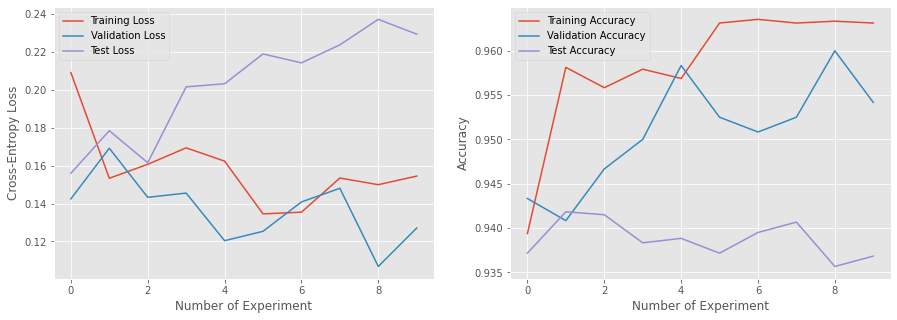

In [84]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.plot(test_loss,label='Test Loss')
plt.xlabel('Number of Experiment')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.plot(test_acc,label='Test Accuracy')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## ANN Results

Belwo the results for the ANN are generated.

In [85]:
f = pd.get_dummies(features)

model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=400, batch_size=50)

Epoch 1/400
96/96 [==============================] - 1s 3ms/step - loss: 2.0273 - accuracy: 0.5180 - val_loss: 0.5779 - val_accuracy: 0.7308
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.6624 - accuracy: 0.7410 - val_loss: 0.4313 - val_accuracy: 0.8225
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.5229 - accuracy: 0.8089 - val_loss: 0.3653 - val_accuracy: 0.8542
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.5251 - accuracy: 0.8219 - val_loss: 0.3230 - val_accuracy: 0.8783
Epoch 5/400
96/96 [==============================] - 0s 2ms/step - loss: 0.5014 - accuracy: 0.8191 - val_loss: 0.3153 - val_accuracy: 0.8608
Epoch 6/400
96/96 [==============================] - 0s 2ms/step - loss: 0.4473 - accuracy: 0.8427 - val_loss: 0.2864 - val_accuracy: 0.8908
Epoch 7/400
96/96 [==============================] - 0s 2ms/step - loss: 0.4153 - accuracy: 0.8502 - val_loss: 0.2726 - val_accuracy: 0.8925
Epoch 8/400
9

Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2328 - accuracy: 0.9301 - val_loss: 0.1369 - val_accuracy: 0.9558
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2364 - accuracy: 0.9297 - val_loss: 0.1446 - val_accuracy: 0.9508
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2555 - accuracy: 0.9252 - val_loss: 0.1444 - val_accuracy: 0.9475
Epoch 62/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2326 - accuracy: 0.9306 - val_loss: 0.1409 - val_accuracy: 0.9517
Epoch 63/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2318 - accuracy: 0.9246 - val_loss: 0.1319 - val_accuracy: 0.9567
Epoch 64/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2293 - accuracy: 0.9264 - val_loss: 0.1335 - val_accuracy: 0.9592
Epoch 65/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2130 - accuracy: 0.9258 - val_loss: 0.1342 - val_accuracy: 0.9550
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.2060 - accuracy: 0.9313 - val_loss: 0.1192 - val_accuracy: 0.9600
Epoch 117/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2203 - accuracy: 0.9359 - val_loss: 0.1233 - val_accuracy: 0.9608
Epoch 118/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2083 - accuracy: 0.9349 - val_loss: 0.1191 - val_accuracy: 0.9500
Epoch 119/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2188 - accuracy: 0.9360 - val_loss: 0.1176 - val_accuracy: 0.9533
Epoch 120/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1813 - accuracy: 0.9363 - val_loss: 0.1172 - val_accuracy: 0.9492
Epoch 121/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1893 - accuracy: 0.9380 - val_loss: 0.1217 - val_accuracy: 0.9633
Epoch 122/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2085 - accuracy: 0.9359 - val_loss: 0.1215 - val_accuracy: 0.9492
Epoch 123/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2071 - accuracy: 0.9406 - val_loss: 0.1263 - val_accuracy: 0.9617
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2106 - accuracy: 0.9379 - val_loss: 0.1166 - val_accuracy: 0.9542
Epoch 175/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1734 - accuracy: 0.9420 - val_loss: 0.1157 - val_accuracy: 0.9508
Epoch 176/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2072 - accuracy: 0.9437 - val_loss: 0.1241 - val_accuracy: 0.9633
Epoch 177/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2479 - accuracy: 0.9363 - val_loss: 0.1154 - val_accuracy: 0.9550
Epoch 178/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2234 - accuracy: 0.9374 - val_loss: 0.1175 - val_accuracy: 0.9542
Epoch 179/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1884 - accuracy: 0.9439 - val_loss: 0.1246 - val_accuracy: 0.9492
Epoch 180/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2182 - accuracy: 0.9384 - val_loss: 0.1157 - val_accuracy: 0.9592
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1699 - accuracy: 0.9542 - val_loss: 0.1348 - val_accuracy: 0.9467
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2049 - accuracy: 0.9421 - val_loss: 0.1249 - val_accuracy: 0.9467
Epoch 233/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1942 - accuracy: 0.9423 - val_loss: 0.1166 - val_accuracy: 0.9550
Epoch 234/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1906 - accuracy: 0.9412 - val_loss: 0.1241 - val_accuracy: 0.9525
Epoch 235/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1847 - accuracy: 0.9434 - val_loss: 0.1132 - val_accuracy: 0.9533
Epoch 236/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1869 - accuracy: 0.9407 - val_loss: 0.1146 - val_accuracy: 0.9583
Epoch 237/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1990 - accuracy: 0.9462 - val_loss: 0.1117 - val_accuracy: 0.9575
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1795 - accuracy: 0.9420 - val_loss: 0.1248 - val_accuracy: 0.9608
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1752 - accuracy: 0.9478 - val_loss: 0.1181 - val_accuracy: 0.9633
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1726 - accuracy: 0.9511 - val_loss: 0.1169 - val_accuracy: 0.9550
Epoch 291/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2002 - accuracy: 0.9496 - val_loss: 0.1338 - val_accuracy: 0.9433
Epoch 292/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1622 - accuracy: 0.9462 - val_loss: 0.1185 - val_accuracy: 0.9550
Epoch 293/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1793 - accuracy: 0.9468 - val_loss: 0.1145 - val_accuracy: 0.9508
Epoch 294/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1847 - accuracy: 0.9506 - val_loss: 0.1314 - val_accuracy: 0.9458
Epoch 345/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1786 - accuracy: 0.9466 - val_loss: 0.1127 - val_accuracy: 0.9567
Epoch 346/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1937 - accuracy: 0.9443 - val_loss: 0.1170 - val_accuracy: 0.9525
Epoch 347/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2007 - accuracy: 0.9450 - val_loss: 0.1207 - val_accuracy: 0.9525
Epoch 348/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1752 - accuracy: 0.9549 - val_loss: 0.1141 - val_accuracy: 0.9575
Epoch 349/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2102 - accuracy: 0.9472 - val_loss: 0.1254 - val_accuracy: 0.9483
Epoch 350/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1599 - accuracy: 0.9497 - val_loss: 0.1136 - val_accuracy: 0.9583
Epoch 351/400

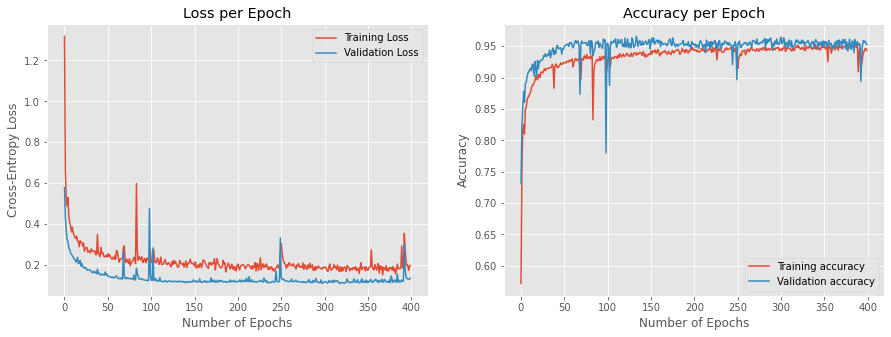

In [86]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'Training accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [87]:
yy_test = pd.get_dummies(yy)
results = model.evaluate(xx_dummy, yy_test, batch_size=128)
#y_hat = model.predict_classes(xx_dummy, verbose=1)
#y_hat_dummy = pd.get_dummies(y_hat)
print("test loss, test acc:", results)
#print(sklearn.metrics.f1_score(y_hat_dummy, yy_test,average='micro'))

47/47 [==============================] - 0s 2ms/step - loss: 0.1652 - accuracy: 0.9372
test loss, test acc: [0.16521786153316498, 0.937166690826416]


In [88]:
results[0]

0.16521786153316498

## Below the results for the Support Vector Machine are Generated

The label is transformed such that unsatisfied or neutral passengers are coded as -1 and satisfied passenger are coded as 1. 

In [89]:
svm_y = np.empty((len(features),1))

for i in range(len(features)):
    if features.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)


clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training Accuracy:  0.9470833333333334
Validation Accuracy:  0.9241666666666667


### Get results for the Test data

In [90]:
svm_y_test = np.empty((len(yy),1))

for i in range(len(yy)):
    if yy.iloc[i] == 1:
        svm_y_test[i] = 1
    else:
        svm_y_test[i] = -1

In [91]:
y_pred = clf.predict(xx_dummy)
print('Test Accuracy: ',clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test,average='micro'))

Test Accuracy:  0.929
0.929


## Results for the Random Forest Classifier

In [92]:
clf = RandomForestClassifier(max_depth=None, random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)

clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

<ipython-input-92-658d8ea662f0>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Training Accuracy:  1.0
Validation Accuracy:  0.9608333333333333


In [93]:
y_pred = clf.predict(xx_dummy)
print('Test Accuracy: ',clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

Test Accuracy:  0.9488333333333333
0.939673806248772


## Results for AdaBoost

In [94]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training Accuracy:  0.9347916666666667
Validation Accuracy:  0.9325
Test Accuracy:  0.388
0.9163550482188546


## Results for Naive Bayes

In [95]:
clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

Training Accuracy:  0.8708333333333333
Validation Accuracy:  0.8766666666666667
Test Accuracy:  0.35783333333333334
0.8404775885691917


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


## Results for QDA

In [96]:
clf = QDA()
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))

Training Accuracy:  0.7147916666666667
Validation Accuracy:  0.7183333333333334
Test Accuracy:  0.20666666666666667


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## Results for Logistic Regression

In [97]:
x_train, x_test, y_train, y_test = train_test_split(x_wd,features, test_size = 0.2, shuffle=True)
clf = LogisticRegression(random_state=0,max_iter=500).fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, yy))

Training Accuracy:  0.873125
Validation Accuracy:  0.8933333333333333
Test Accuracy:  0.8665
0.8422296631869214
